In [1]:
import itertools
import numpy as np
import pandas as pd
from scipy import signal
from scipy import fftpack
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

mpl.rcParams["image.cmap"] = "Greys"
mpl.rcParams["image.origin"] = "lower"

# %load_ext lab_black
# %config InlineBackend.figure_format = "retina"

# 0. Background knowledge

## 0.1 Length & orientation of the baseline in polar coordinates
Two stations, $\vec A(\theta_1, r_1,)$ and $\vec B(\theta_2, r_2)$, form a baseline $\vec L=\vec B -\vec A=\vec L(\theta,L)$

$$x_{1,2}=r_{1,2}\cos\theta_{1,2}$$

$$y_{1,2}=r_{1,2}\sin\theta_{1,2}$$

$$L=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$$

$$\tan\theta=\dfrac{y_2-y_1}{x_2-x_1}$$

In [2]:
def polar_dist_angle(A, B):
    theta1, r1 = A  # rad
    theta2, r2 = B  # rad
    x1 = r1 * np.cos(theta1)
    y1 = r1 * np.sin(theta1)
    x2 = r2 * np.cos(theta2)
    y2 = r2 * np.sin(theta2)
    dist = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    angle = np.arctan2(y2 - y1, x2 - x1)
    return dist, angle  # rad

### Demo 1

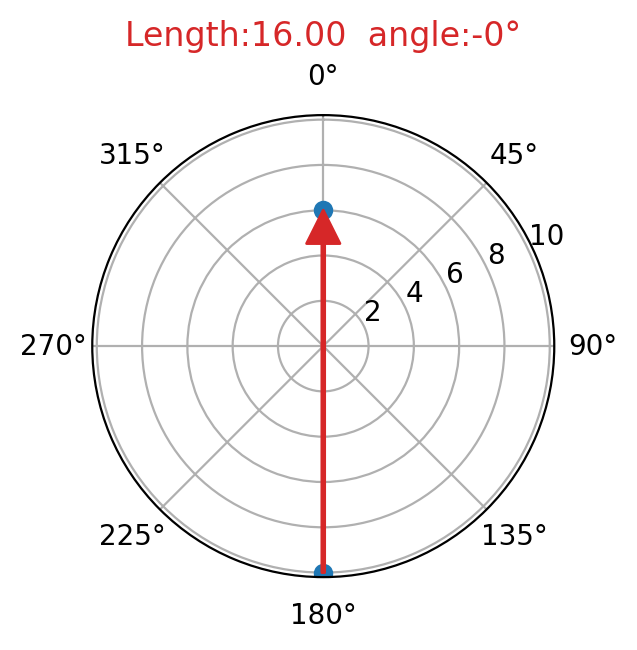

In [3]:
A, B = (np.pi, 10), (0, 6)
L, theta = polar_dist_angle(A, B)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection="polar")
ax.plot([A[0], B[0]], [A[1], B[1]], "o")
ax.annotate(
    "",
    xy=B,
    xytext=A,
    arrowprops=dict(facecolor="C3", edgecolor="C3", width=1),
)
ax.set_rlabel_position(65)
ax.set_theta_zero_location("N")
ax.set_theta_direction("clockwise")
ax.set_title(f"Length:{L:.2f}  angle:{np.degrees(theta):.0f}°", c="C3")
plt.show()

### Demo 2

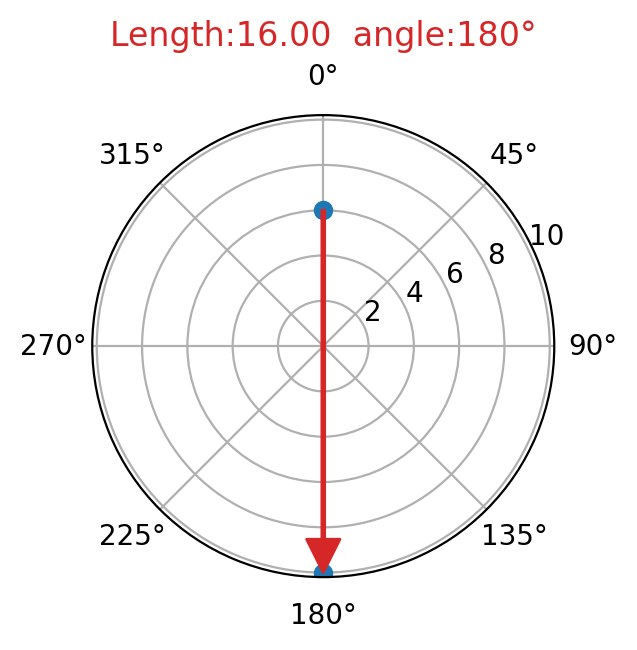

In [4]:
A, B = (0, 6), (np.pi, 10)
L, theta = polar_dist_angle(A, B)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection="polar")
ax.plot([A[0], B[0]], [A[1], B[1]], "o")
ax.annotate(
    "",
    xy=B,
    xytext=A,
    arrowprops=dict(facecolor="C3", edgecolor="C3", width=1),
)
ax.set_rlabel_position(65)
ax.set_theta_zero_location("N")
ax.set_theta_direction("clockwise")
ax.set_title(f"Length:{L:.2f}  angle:{np.degrees(theta):.0f}°", c="C3")
plt.show()

### Demo 3

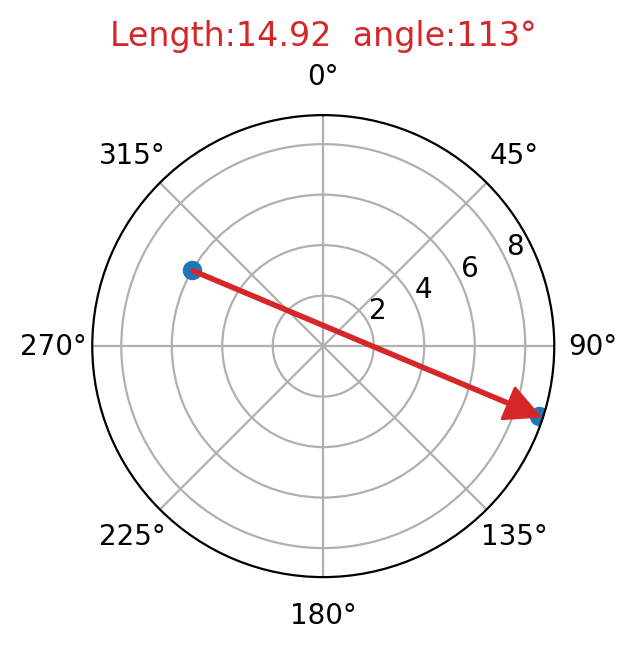

In [5]:
A, B = (-np.pi / 3, 6), (3 * np.pi / 5, 9)
L, theta = polar_dist_angle(A, B)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection="polar")
ax.plot([A[0], B[0]], [A[1], B[1]], "o")
ax.annotate(
    "",
    xy=B,
    xytext=A,
    arrowprops=dict(facecolor="C3", edgecolor="C3", width=1),
)
ax.set_rlabel_position(65)
ax.set_theta_zero_location("N")
ax.set_theta_direction("clockwise")
ax.set_title(f"Length:{L:.2f}  angle:{np.degrees(theta):.0f}°", c="C3")
plt.show()

### Demo 4

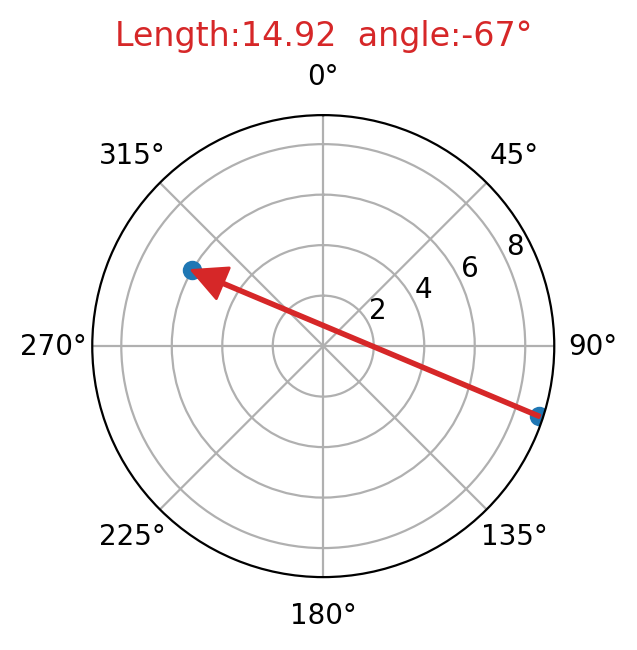

In [6]:
A, B = (3 * np.pi / 5, 9), (-np.pi / 3, 6)
L, theta = polar_dist_angle(A, B)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection="polar")
ax.plot([A[0], B[0]], [A[1], B[1]], "o")
ax.annotate(
    "",
    xy=B,
    xytext=A,
    arrowprops=dict(facecolor="C3", edgecolor="C3", width=1),
)
ax.set_rlabel_position(65)
ax.set_theta_zero_location("N")
ax.set_theta_direction("clockwise")
ax.set_title(f"Length:{L:.2f}  angle:{np.degrees(theta):.0f}°", c="C3")
plt.show()

## 0.2 Dec & hour angle of the baseline
If latitude $\phi$, altitude $a$ and azimuth $A$ are given, what are hour angle $h$ and declination $\delta$?

$$\sin(\delta) = \sin(a)\sin(\phi)+\cos(a)\cos(\phi)\cos(A)$$

$$\sin(h) = -\sin(A)\cos(a)/\cos(\delta)$$

<center><img src=https://i.imgur.com/bf6oY8W.jpg width="500"></center>

Note: `np.arcsin(x)` will return the inverse sine of x, in radians and in the closed interval $[-\pi/2, \pi/2]$

Note: $\sin(x)=\sin(\pi-x)$ the exact value of hour angle $h$ depends on $A$ ⚠️

In [7]:
def horz2eq(phi, A, a=0):
    """
    phi: latitude [rad]
    A: azimuth [rad]
    a: altitude [rad]
    """
    dec = np.arcsin(np.sin(a) * np.sin(phi) + np.cos(a) * np.cos(phi) * np.cos(A))
    h = np.arcsin(-np.sin(A) * np.cos(a) / np.cos(dec))
    if np.cos(A) > 0:
        h = np.pi - h
    return dec, h  # rad

### Demo

In [8]:
for A in [0, 90, 180, 270, 10, 170, 190, 350]:
    dec, h = horz2eq(phi=np.radians(45), A=np.radians(A))
    print(f"A={A:>3.0f}°   dec={np.degrees(dec):>3.0f}°   h={np.degrees(h):>3.0f}°")

A=  0°   dec= 45°   h=180°
A= 90°   dec=  0°   h=270°
A=180°   dec=-45°   h= -0°
A=270°   dec= -0°   h= 90°
A= 10°   dec= 44°   h=194°
A=170°   dec=-44°   h=-14°
A=190°   dec=-44°   h= 14°
A=350°   dec= 44°   h=166°


## 0.3 UV track from a given baseline
$$u=\dfrac L\lambda\cos d\sin(H-h)$$

$$v=\dfrac L\lambda\left[\sin d\cos D-\cos d\sin D\cos(H-h)\right]$$

- $H$ - HA of the source → vary over time
- $h$ - HA of the baseline → fixed
- $D$ - Dec of the source → fixed
- $d$ - Dec of the baseline → fixed

In [9]:
def uv(
    L=100, wavelength=1, H=np.linspace(0, 2 * np.pi, 100), h=0, D=np.pi / 2, d=np.pi / 4
):  # rad
    u = L / wavelength * np.cos(d) * np.sin(H - h)
    v = L / wavelength * (np.sin(d) * np.cos(D) - np.cos(d) * np.sin(D) * np.cos(H - h))
    return u, v

### Demo 1
NS baseline at equator (d=90°) → compleletly useless

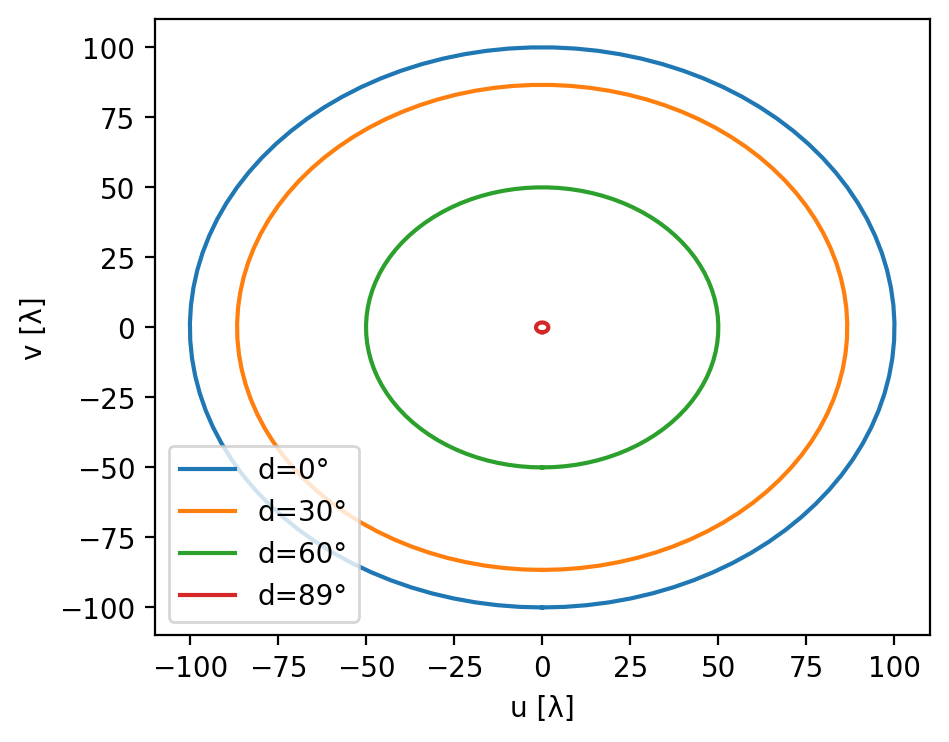

In [10]:
plt.figure(figsize=(5, 4))
for d in [0, 30, 60, 89]:
    plt.plot(*uv(d=np.radians(d)), label=f"d={d}°")
plt.xlabel("u [λ]")
plt.ylabel("v [λ]")
plt.legend()
plt.show()

### Demo 2
Difficult to image sources at D=0

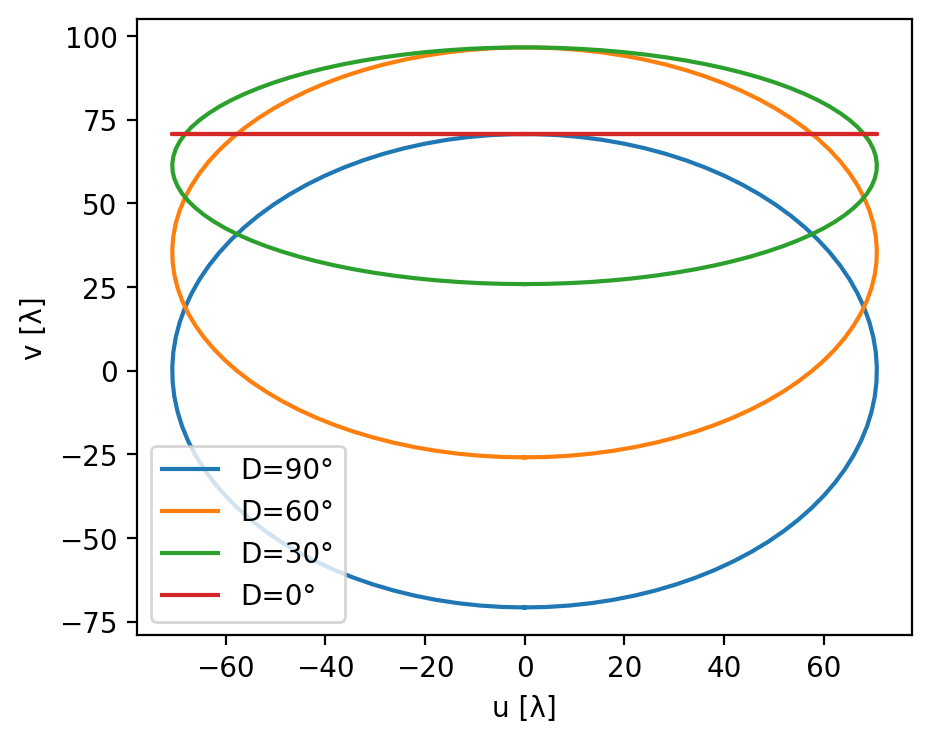

In [11]:
plt.figure(figsize=(5, 4))
for D in [90, 60, 30, 0]:
    plt.plot(*uv(D=np.radians(D)), label=f"D={D}°")
plt.xlabel("u [λ]")
plt.ylabel("v [λ]")
plt.legend(loc="lower left")
plt.show()

## 0.4 Dirty beam (PSF)

UV track →

$$\displaystyle F(u, v) =\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(x, y) e^{-i 2 \pi(u x+v y)} \mathrm d x\mathrm d y$$

Dirty beam (PSF) →

$$\displaystyle f(x, y) =\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} F(u, v) e^{i 2 \pi(u x+v y)} \mathrm d u\mathrm d v$$

<center><img src=https://i.imgur.com/tTj7KY6.png width="500"></center>

Note:
- the pixel size of the dirty beam map is determined by the uv_max of the uv image
- the size of the dirty beam map is determined by the pixel size of the uv image

For example, if the pixel size of the uv image is $a$ (in the unit of λ), the size of the dirty beam map is thus $1/a$ rad.

In [12]:
def UV_demo(UV_list, uvmax=500, uvlim=10):
    uv_pixel_size = 1  # in the unit of kλ
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 2.5))
    array2D = np.zeros((2 * uvmax // uv_pixel_size, 2 * uvmax // uv_pixel_size))
    for u, v in UV_list:
        array2D[int(u + uvmax), int(v + uvmax)] = 1
    fft = fftpack.fftshift(fftpack.fftn(fftpack.fftshift(array2D)))
    real = np.round(np.real(fft), 5)
    imag = np.round(np.imag(fft), 5)
    magnitude = np.round(np.abs(fft), 5)
    map_size = np.degrees(1 / uv_pixel_size / 1e3) * 60 / 2  # arcmin

    ax1.imshow(
        array2D,
        cmap="bwr",
        vmin=-1,
        extent=[-uvmax - 0.5, uvmax - 0.5, -uvmax - 0.5, uvmax - 0.5],
    )
    ax1.set_xlim(-uvlim, uvlim)
    ax1.set_ylim(-uvlim, uvlim)
    ax1.set_xlabel("u [kλ]", size=12)
    ax1.set_ylabel("v [kλ]", size=12)
    ax1.grid()

    for ax, data, title in zip(
        [ax2, ax3, ax4], [real, imag, magnitude], ["Real", "Imaginary", "Magnitude"]
    ):
        ax.imshow(data, extent=[-map_size, map_size, -map_size, map_size])
        ax.set_title(title)
        ax.set_xlabel("$\\theta_x$ offset [arcmin]")
        ax.set_ylabel("$\\theta_y$ offset [arcmin]")
    f.tight_layout()
    return real, imag, magnitude, map_size

### Demo 1 - single point

If there is only one point $(u_0, v_0)$ in the UV plane (delta function),

$${\displaystyle F(u,v)={\begin{cases}1 & u=u_0,\ v=v_0,\\0&{\text{otherwise}}.\end{cases}}}$$

the integration over the entire UV plane is equivalent to the value of the function at a particular non-zero point.

$$\displaystyle f(x, y) =\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} F(u, v) e^{i 2 \pi(u x+v y)} \mathrm d u\mathrm d v=e^{i 2 \pi(u_0 x+v_0 y)}=\cos{2 \pi(u_0x+v_0y)}+i\sin{2 \pi(u_0x+v_0y)}$$

Thus, the real and imaginary components are both sinusoidal, and the magnitude equals 1 (The FT of a delta function is a uniform function). The sinusoidal fringe spacing is $\frac{1}{\sqrt{u_0^2+v_0^2}}$ radians.

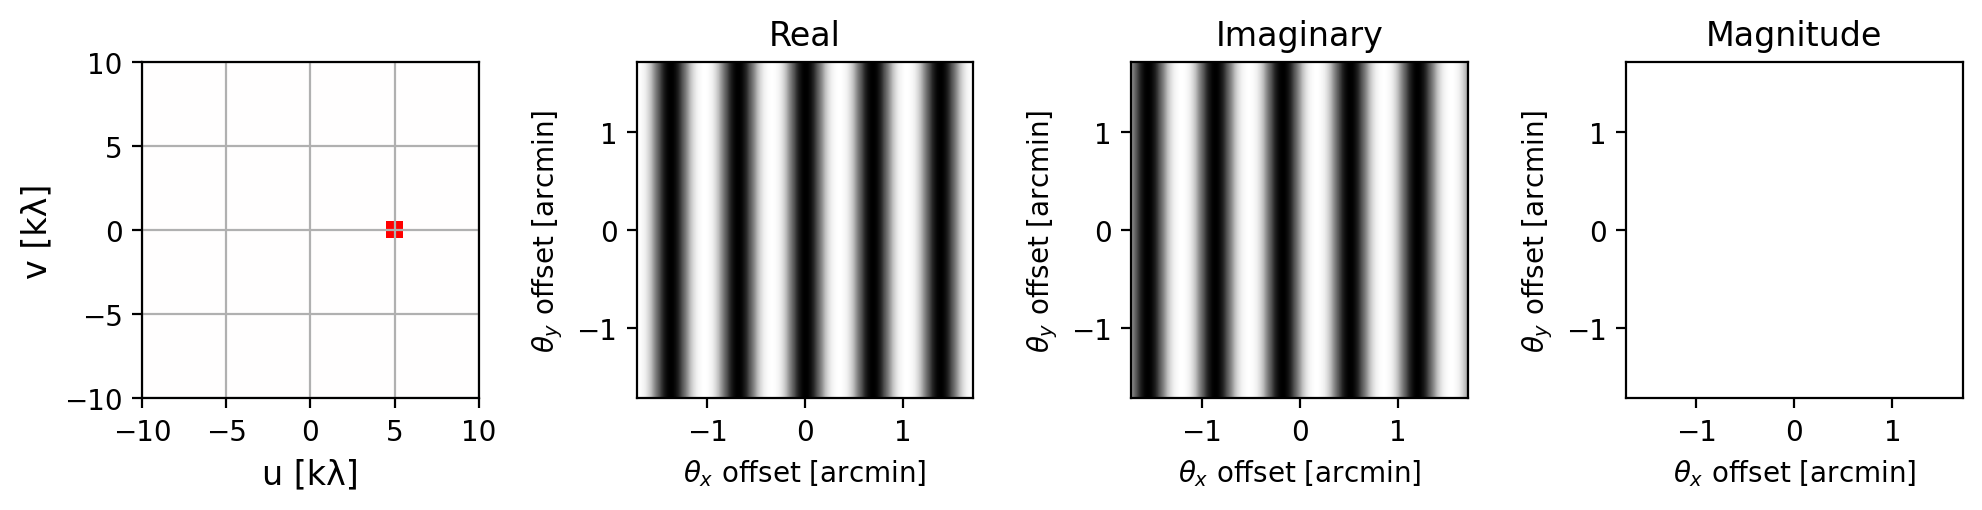

In [13]:
real, imag, magnitude, map_size = UV_demo([(0, 5)])

Different position on the UV surface leads to phase change, while the magnitude remains the same.

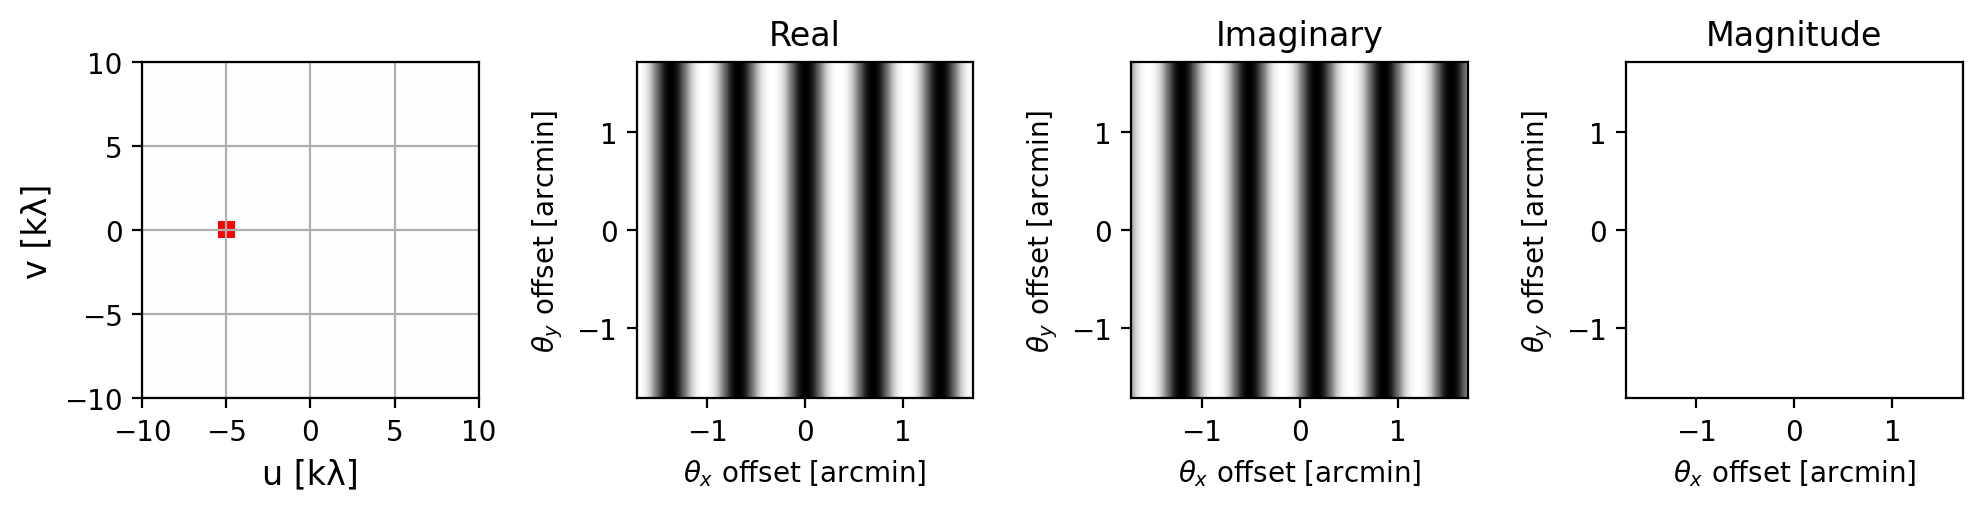

In [14]:
real, imag, magnitude, map_size = UV_demo([(0, -5)])

### Demo 2 - a pair of conjugate points

If a pair of points has point symmetry with respect to the origin $u\to-u,~v\to-v$, the imaginary component would be cancelled out and the magnitude is the square of the real component, i.e. $\cos^2$. That is to say the FT of real signals is always conjugate symmetric.

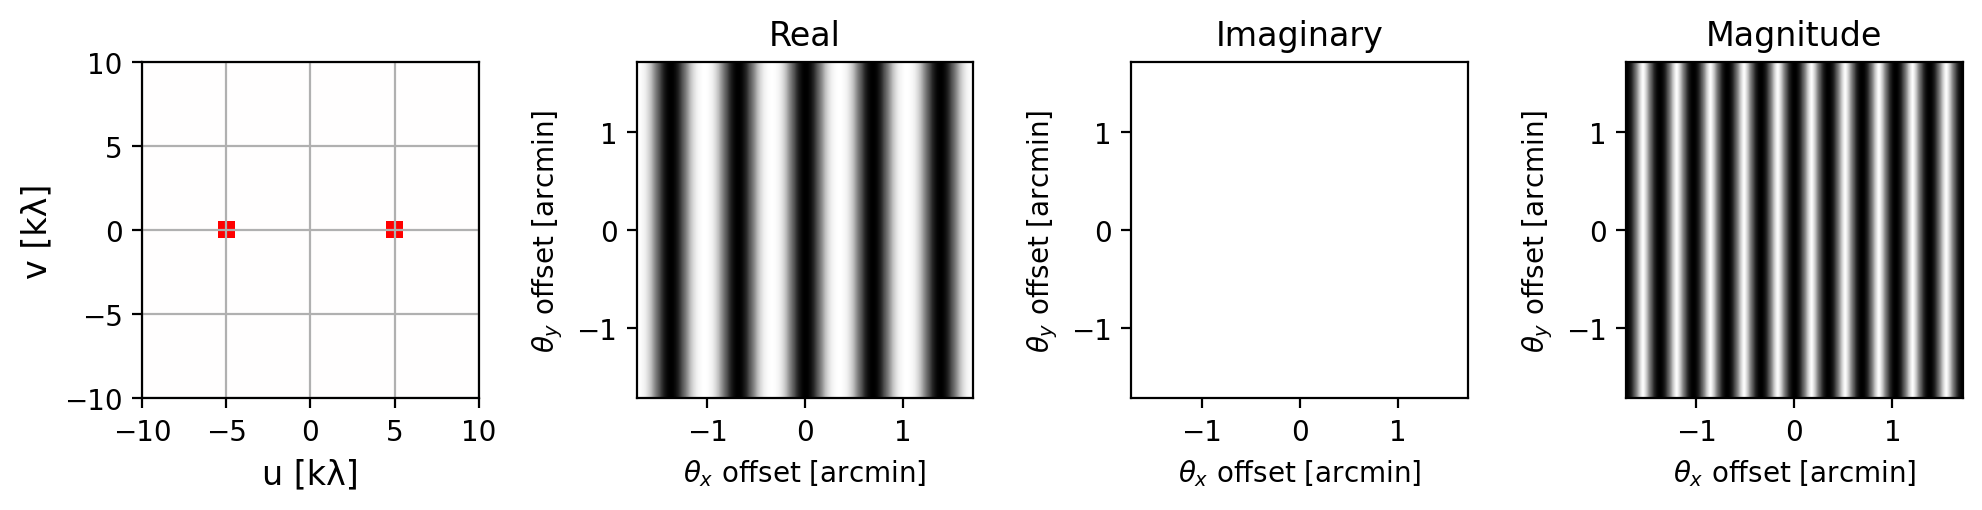

In [15]:
real, imag, magnitude, map_size = UV_demo([(0, 5), (0, -5)])

- **magnitude** → **frequency** of the fringes
- **direction** → **orientation** of the fringes

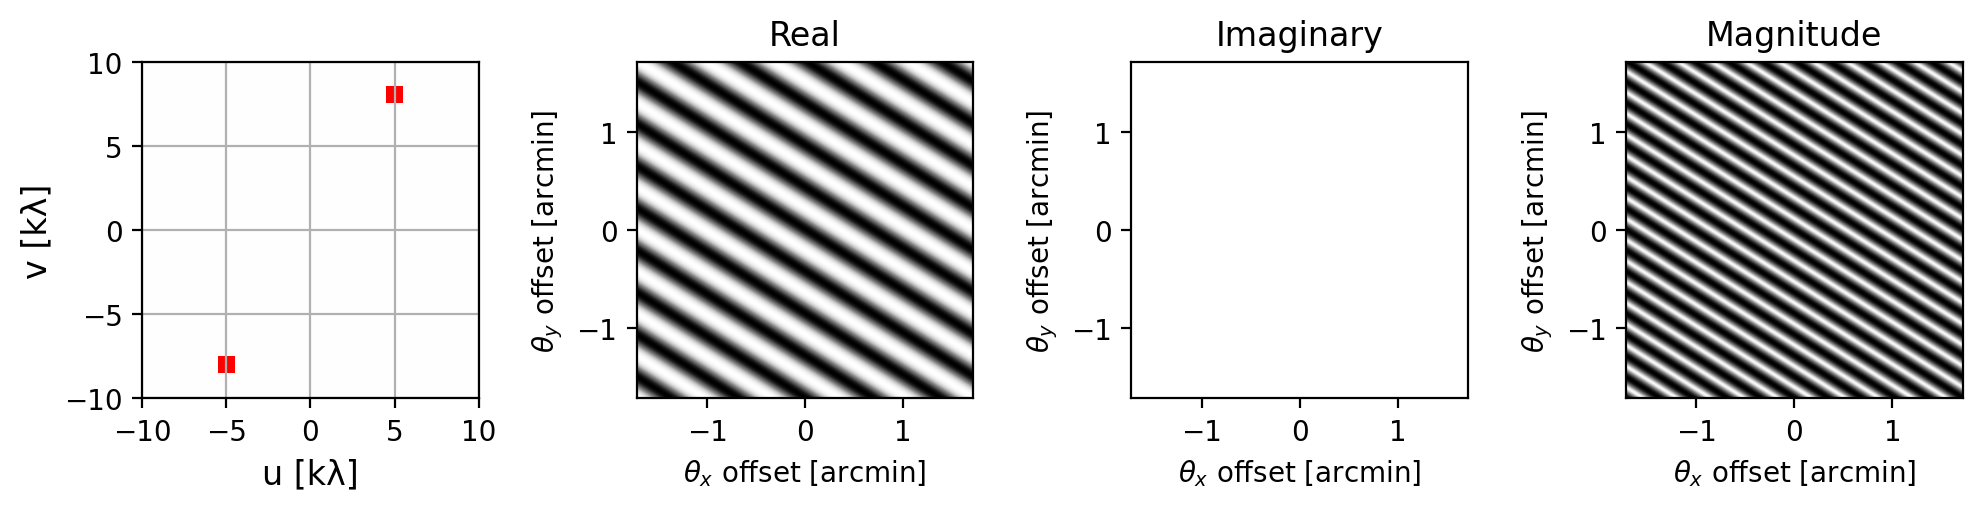

In [16]:
real, imag, magnitude, map_size = UV_demo([(8, 5), (-8, -5)])

### Demo 3 - disk

The FT of a top-hat function is a sinc function.

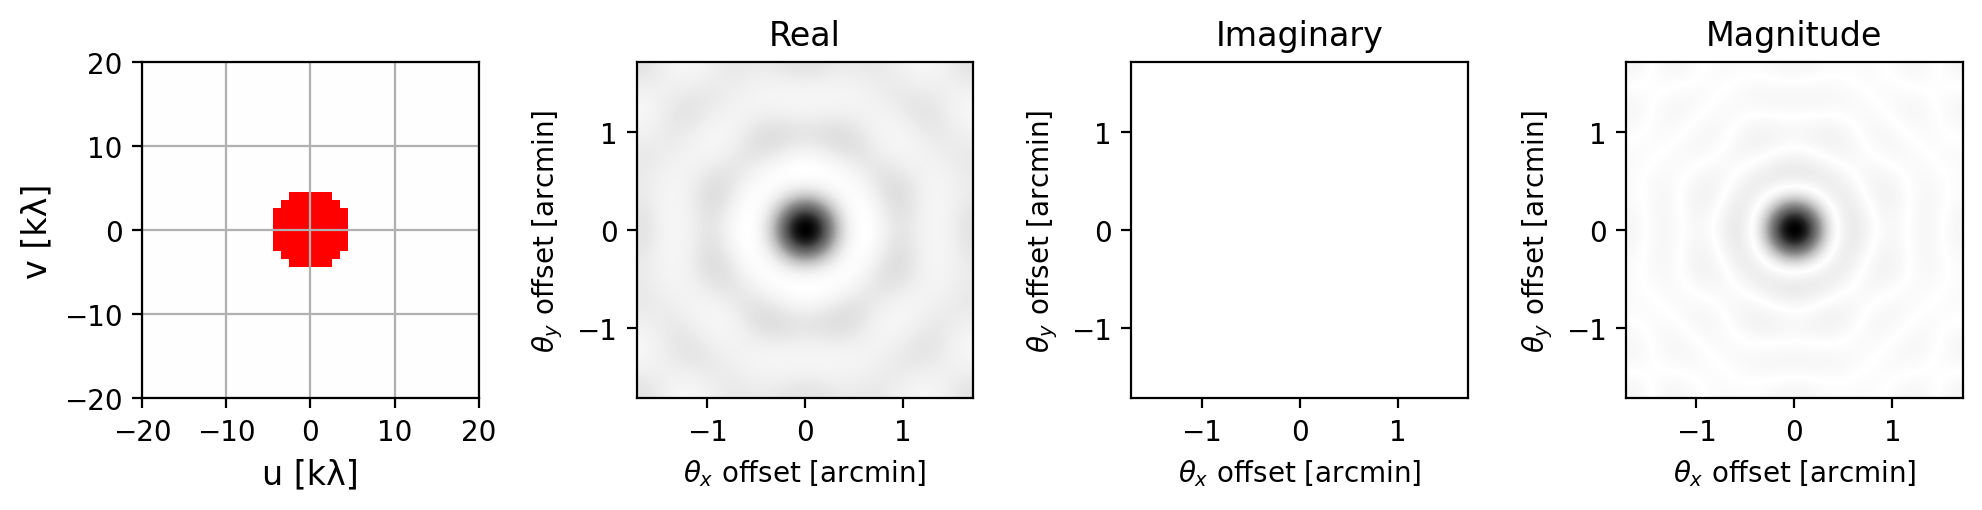

In [17]:
uv_list = []
for i in range(-5, 6):
    for j in range(-5, 6):
        if i**2 + j**2 < 5**2:
            uv_list.append((i, j))
real, imag, magnitude1, map_size = UV_demo(uv_list, uvlim=20)

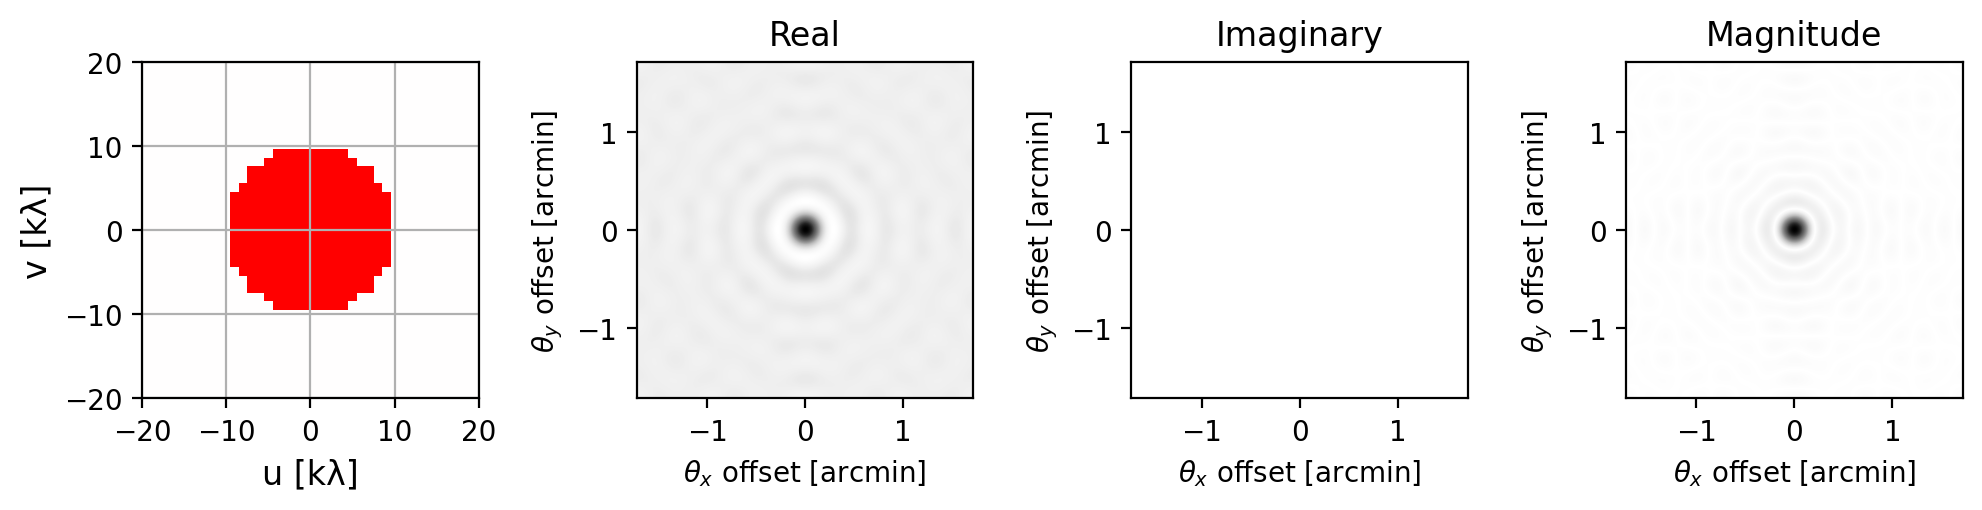

In [18]:
uv_list = []
for i in range(-10, 11):
    for j in range(-10, 11):
        if i**2 + j**2 < 10**2:
            uv_list.append((i, j))
real, imag, magnitude2, map_size = UV_demo(uv_list, uvlim=20)

The FT of a uniform function is a delta function. Therfore, the more coverage in the uv plane, the closer the PSF is to the delta function.

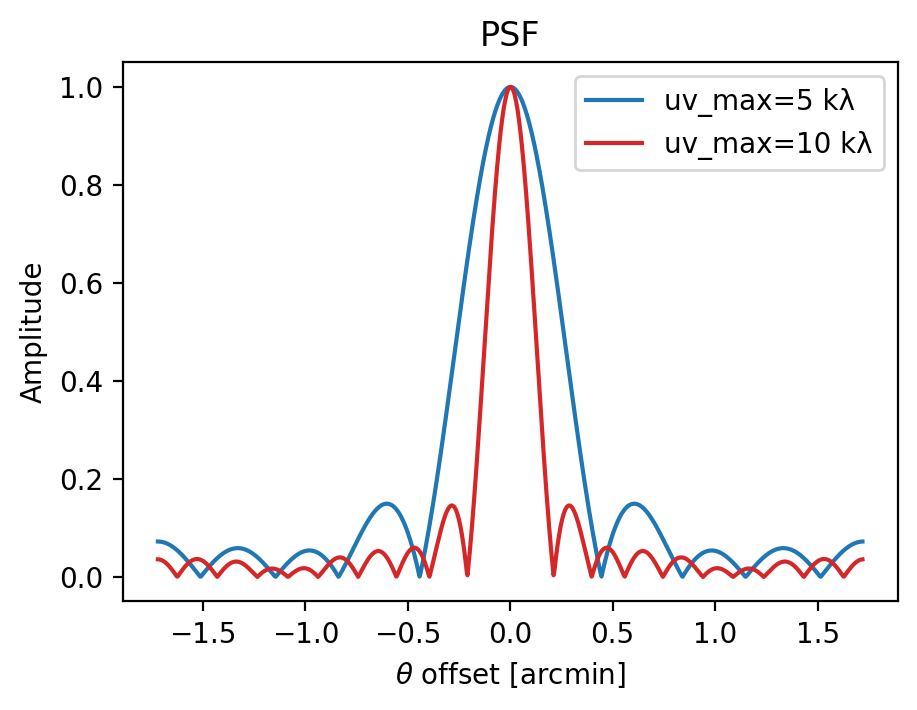

In [19]:
y1 = magnitude1[500, :]
y2 = magnitude2[500, :]
y1 /= y1.max()
y2 /= y2.max()
x = np.linspace(-map_size, map_size, len(y1))
plt.figure(figsize=(5, 3.5))
plt.plot(x, y1, label="uv_max=5 kλ")
plt.plot(x, y2, "C3", label="uv_max=10 kλ")
plt.xlabel("$\\theta$ offset [arcmin]")
plt.ylabel("Amplitude")
plt.title("PSF")
plt.legend()
plt.show()

## 0.5 Convolution
The dirty map observed by an interferometer is the convolution of the true sky brightness distribution and the dirty beam (PSF) of the interferometer.

<center><img src=https://i.imgur.com/tTj7KY6.png width="500"></center>

Therefore, in addition to doing multiplication in the frequency domain (UV-plane), convolution in the spcae domain is an alternitive approach. To verify this relation, we need to do convolution in Python using `scipy.signal.convolve2d(A, B, boundary="fill", mode="same")`.

An intuitive understanding of convolution is given below 👇

<center><img src=https://i.imgur.com/sPhNQIM.jpg width="400"></center>

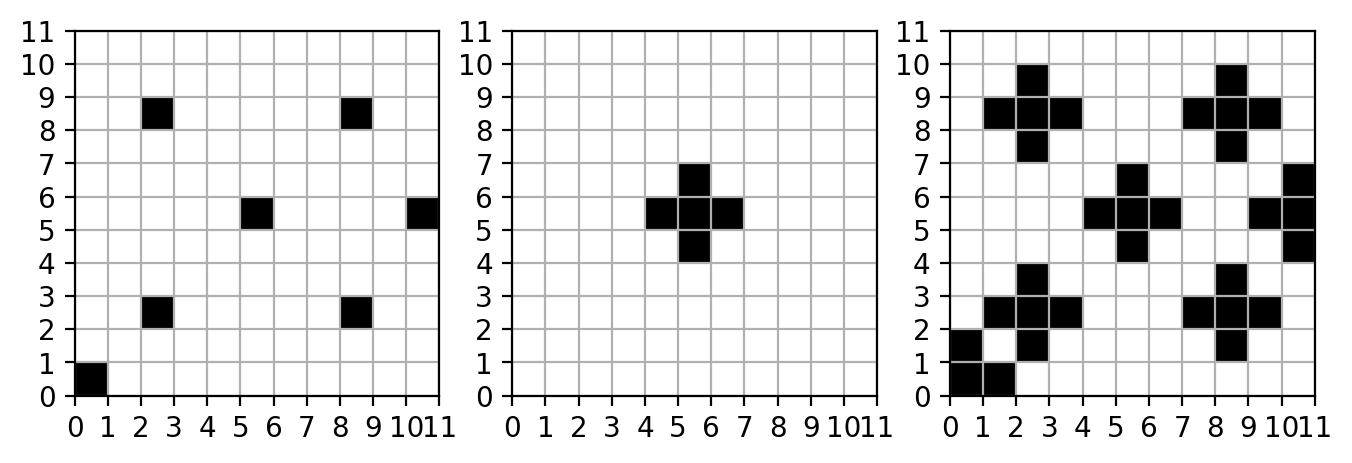

In [20]:
A = np.zeros((11, 11))
for x, y in [[0, 0], [2, 2], [2, 8], [5, 5], [5, 10], [8, 2], [8, 8]]:
    A[x, y] = 1

B = np.zeros((11, 11))
for x, y in [[5, 5], [5, 6], [5, 4], [6, 5], [4, 5]]:
    B[x, y] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5))
ax1.imshow(A, extent=[0, 11, 0, 11])
ax1.set_xticks(range(12))
ax1.set_yticks(range(12))
ax1.grid()

ax2.imshow(B, extent=[0, 11, 0, 11])
ax2.set_xticks(range(12))
ax2.set_yticks(range(12))
ax2.grid()

ax3.imshow(signal.convolve2d(A, B, boundary="fill", mode="same"), extent=[0, 11, 0, 11])
ax3.set_xticks(range(12))
ax3.set_yticks(range(12))
ax3.grid()

## 0.6 Physical angles → RA / Dec
In the previous section, the true sky is expressed in physical angles $\theta_x$ and $\theta_y$. However, RA (right ascension) and Dec (declination) are preferable in astronomy. The conversion between these two coordinates needs to be addressed.

We can imagine a scenario where the FoV of the telescope is fixed 10 degrees, and when the telescope is pointed at the celestial equator, the RA covered is almost 10 degrees, but when the telescope is pointed at the celestial pole, it can easily cover the entire RA from 0-360 degrees. Obviously, the conversion is Dec $\delta$ dependent.

> The Dec coverage is not affected.

<center><img src=https://i.imgur.com/977tn7m.png width="300"></center>

1 degree in v direction = 1 degree in Dec

1 degree in u direction ≠ 1 degree in RA

$2\pi R\cos\delta=R\theta$ → $2\pi$ in Dec

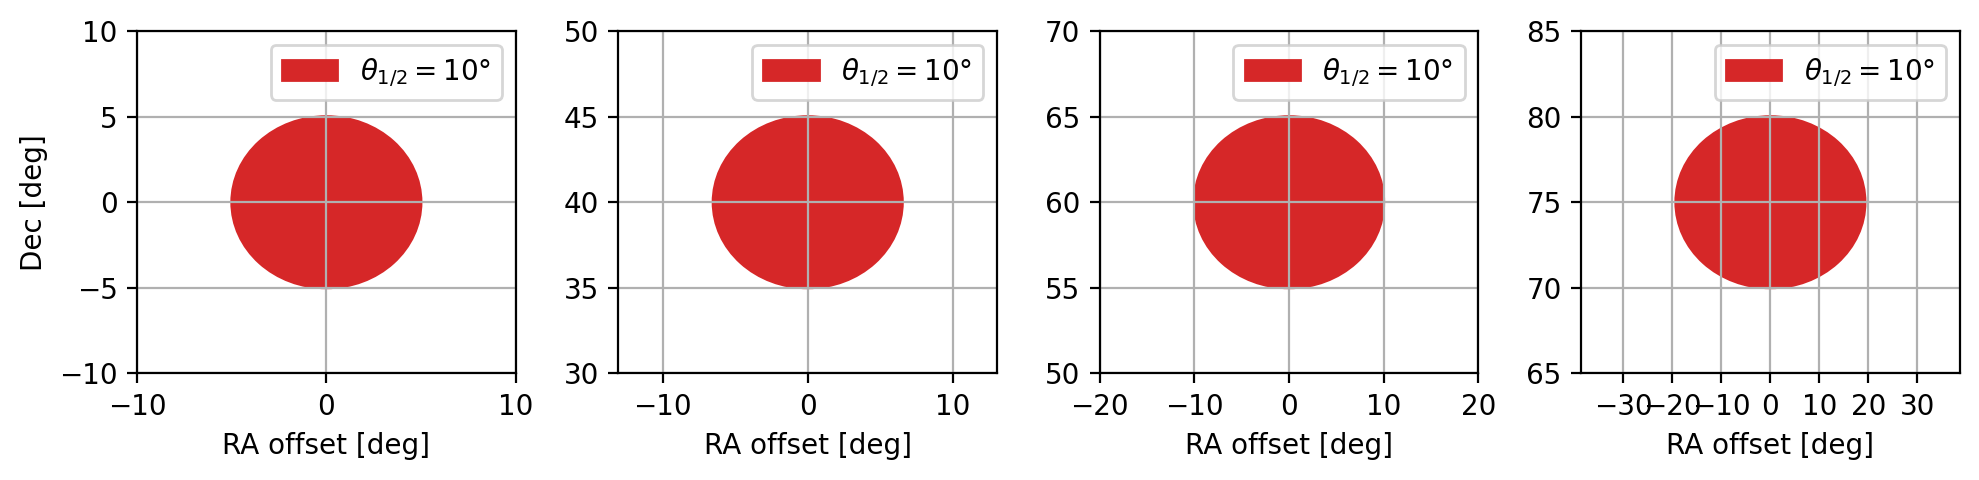

In [21]:
u_degrees = np.array([-10, 10])
v_degrees = np.array([-10, 10])
f, axs = plt.subplots(1, 4, figsize=(10, 2.5))
for i, delta in enumerate([0, 40, 60, 75]):
    RA_degrees = u_degrees / np.cos(np.radians(delta))
    axs[i].add_artist(
        patches.Ellipse(
            (0, delta),
            10 / np.cos(np.radians(delta)),
            10,
            color="C3",
            label="$\\theta_{1/2}=10$°",
        )
    )
    axs[i].imshow(
        np.zeros((10, 10)),
        extent=[
            RA_degrees[0],
            RA_degrees[-1],
            v_degrees[0] + delta,
            v_degrees[-1] + delta,
        ],
        aspect="auto",
    )
    axs[i].legend()
    axs[i].set_xlabel("RA offset [deg]")
    axs[i].set_xticks(np.arange(-100, 100, 10))
    axs[i].set_xlim(RA_degrees[0], RA_degrees[-1])
    axs[i].grid()
axs[0].set_ylabel("Dec [deg]")
f.tight_layout()

# 1. [EVLA](https://science.nrao.edu/facilities/vla/docs/manuals/oss2012B/overview)

The Expanded VLA (EVLA) project is a program to modernize the electronics of the Very Large Array (VLA) that was built in the 1970s and 1980s in order to improve several key observational parameters by an order of magnitude or more.

The EVLA is a 27-element interferometric array, arranged along the arms of an upside-down "Y".

## 1.1 Configurations
> see [An Overview of the VLA](https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview)

The VLA can vary its resolution over a range exceeding a factor of ∼ 50 through movement of its component antennas. There are four basic antenna arrangements, called configurations, whose scales vary by the ratios 1 : 3.28 : 10.8 : 35.5 from smallest to largest. These configurations are denoted D, C, B, and A, respectively. For details about antenna positions in the various configurations we refer to the stations position file ([pdf version](https://science.nrao.edu/facilities/vla/docs/manuals/oss/ant_positions.pdf)).

> see [An Introduction to the NRAO Very Large Array](https://library.nrao.edu/public/memos/vla/misc/VLAU_20.pdf)

Within a single configuration the distance of the antenna stations from the center of the wye is proportional to $m^{1.716}$, where $m$ is an antenna location number, counting outwards along each arm. The power 1.716 is equal to the logarithm to the base 2 of the scale factor between adjacent configurations (3.285).

The azimuths of the arms are:
- north arm: 354°59'48"
- southeast arm: 114°59'42"
- southwest arm: 236°00'05"


The geodetic coordinates of the center of the array are:
- latitude 34°04'43.497" north
- longitude 107°37'03.819" west


The height of the center point of the array is 2124 m above sea level and the height variations along the arms lie within ±32 m of this altitude.

> see [VLA Configurations](https://public.nrao.edu/vla-configurations/)

In [22]:
phi = np.radians(34 + 4 / 60 + 43.497 / 3600)  # latitude 34°04'43.497" north

### D-configuration

In this project D-configuration is used.

<img src=https://i.imgur.com/tsXCGQi.jpg width="1000">

In [23]:
station = (
    ["W" + str(i) for i in range(1, 10)]
    + ["E" + str(i) for i in range(1, 10)]
    + ["N" + str(i) for i in range(1, 10)]
)
R = "39.95 44.79 89.83 147.19 216.18 295.51 384.93 484.02 592.39 79.96 44.85 89.94 147.44 216.07 295.42 384.93 484.02 592.38 0.84 54.91 94.90 134.89 194.86 266.41 347.07 436.37 534.19".split()
theta = (
    [236 + 5 / 3600] * 9  # southwest arm: 236°00'05"
    + [114 + 59 / 60 + 42 / 3600] * 9  # southeast arm: 114°59'42"
    + [354 + 59 / 60 + 48 / 3600] * 9  # north arm: 354°59'48"
)
theta[0] = 354 + 59 / 60 + 48 / 3600 - 180  # W1 is on the north arm
theta[9] = 354 + 59 / 60 + 48 / 3600 - 180  # E1 is on the north arm

In [24]:
D_config = pd.DataFrame()
D_config["Station"] = station
D_config["R(m)"] = list(map(float, R))
D_config["theta"] = theta
D_config.head()

Station    R(m)       theta
0      W1   39.95  174.996667
1      W2   44.79  236.001389
2      W3   89.83  236.001389
3      W4  147.19  236.001389
4      W5  216.18  236.001389

Note that W1 and E1 stations are on the north arm.

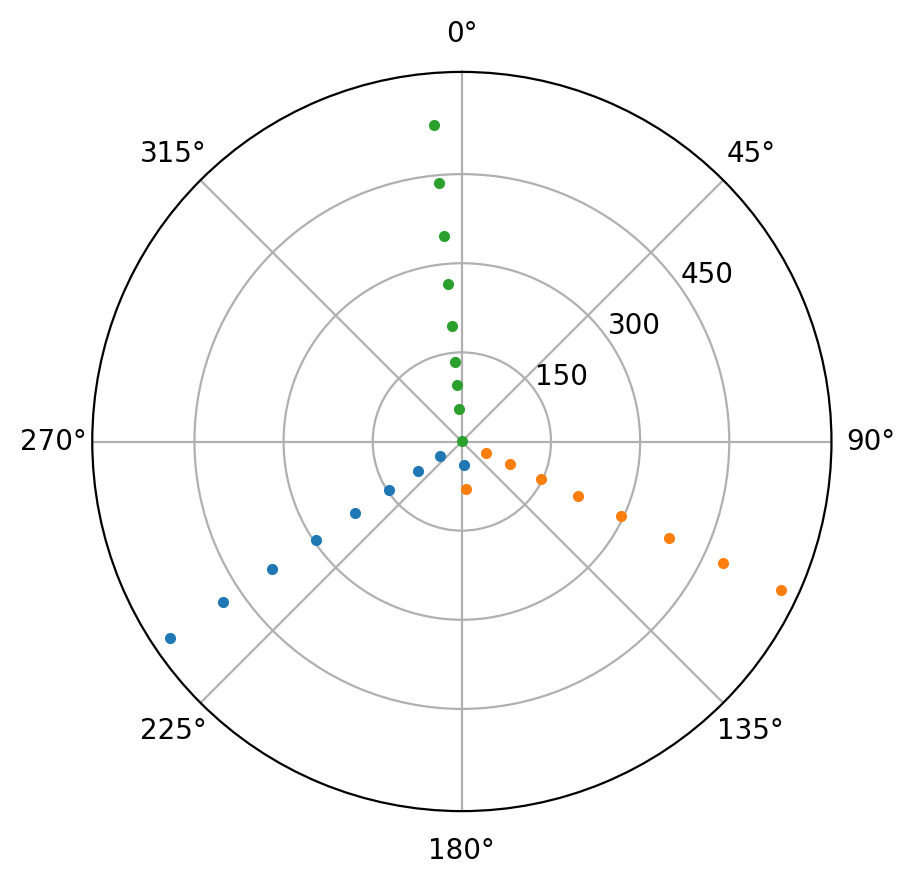

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection="polar")
ax.plot(np.radians(D_config.loc[:8]["theta"]), D_config.loc[:8]["R(m)"], ".")
ax.plot(np.radians(D_config.loc[9:17]["theta"]), D_config.loc[9:17]["R(m)"], ".")
ax.plot(np.radians(D_config.loc[18:]["theta"]), D_config.loc[18:]["R(m)"], ".")

ax.set_rticks([150, 300, 450])
ax.set_rlabel_position(55)
ax.set_theta_zero_location("N")
ax.set_theta_direction("clockwise")
plt.show()

The distance between the centre of the wye and each station on each arm is proportional to $m^{1.716}$

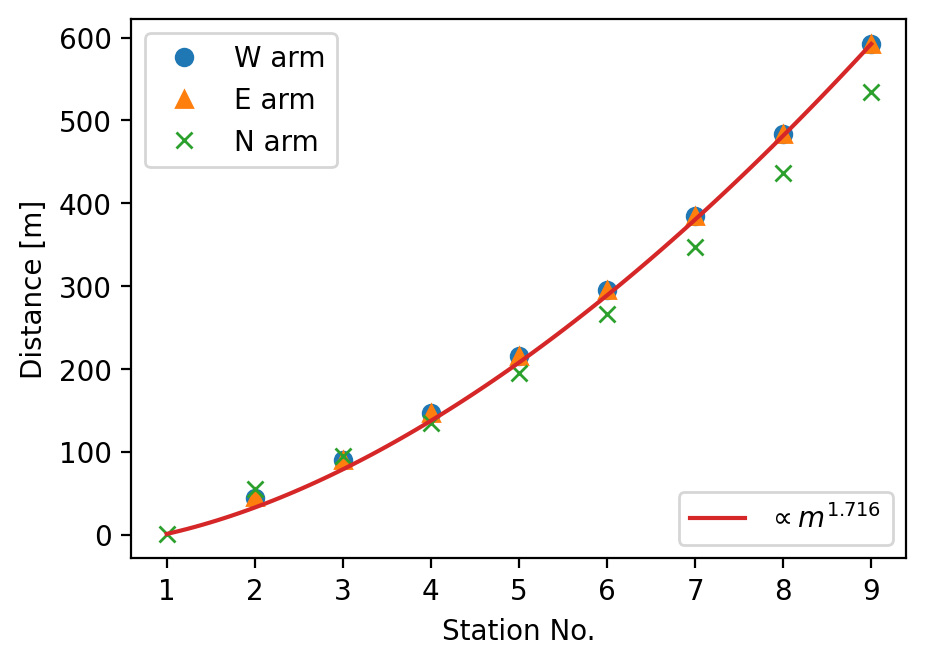

In [26]:
fig = plt.figure(figsize=(5, 3.5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(np.arange(2, 10), D_config.loc[1:8]["R(m)"], "o", label="W arm")
ax1.plot(np.arange(2, 10), D_config.loc[10:17]["R(m)"], "^", label="E arm")
ax1.plot(np.arange(1, 10), D_config.loc[18:]["R(m)"], "x", label="N arm")
ax2.plot(
    np.linspace(1, 9, 100),
    np.linspace(1, 9, 100) ** 1.716,
    label="$\\propto m^{1.716}$",
    c="C3",
)
ax2.axis("off")
ax1.set_xlabel("Station No.")
ax1.set_ylabel("Distance [m]")
ax1.legend()
ax2.legend(loc="lower right")
plt.show()

## 1.2 Bandwidth
> see [An Overview of the VLA](https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview)

All VLA antennas will eventually be outfitted with eight receivers providing continuous frequency coverage from 1 to 50 GHz. These receivers will cover 1-2 GHz, 2-4 GHz, 4-8 GHz, 8-12 GHz, 12-18 GHz, 18-26.5 GHz, 26.5-40 GHz, and 40-50 GHz. These bands are commonly referred to as L, S, C, X, Ku, K, Ka, and Q bands, respectively.

### 5 GHz
In this project, a single frequency of 5GHz is assumed.

In [27]:
wavelength = 3e8 / 5e9  # 5 GHz
wavelength

0.06

# 2. Sources
- Source1:
    - Position: J 05 00 00 + 45 00 00
    - Flux density: 3.6 Jy
    - Should be at the centre of the field-of-view
- Source2:
    - Position: J 05 00 10 + 45 03 00
    - Flux density: 5.8 Jy

In [28]:
D = np.radians(45)  # Dec of the source J 05 00 00 + 45 00 00

# 3. UV coverage

## 3.1 A snapshot when H=0

In [29]:
H = 0  # HA of the source → vary over time
baselines = set(itertools.combinations(range(27), 2))  # all possible baselines

In [30]:
uv_coverage = []
for a, b in baselines:
    A = (np.radians(D_config.loc[a]["theta"]), D_config.loc[a]["R(m)"])
    B = (np.radians(D_config.loc[b]["theta"]), D_config.loc[b]["R(m)"])
    L, angle = polar_dist_angle(A, B)
    d, h = horz2eq(phi, A=angle)
    u, v = uv(L, wavelength, H, h, D, d)
    u /= 1e3  # kλ
    v /= 1e3  # kλ
    uv_coverage.append((u, v))
    uv_coverage.append((-u, -v))

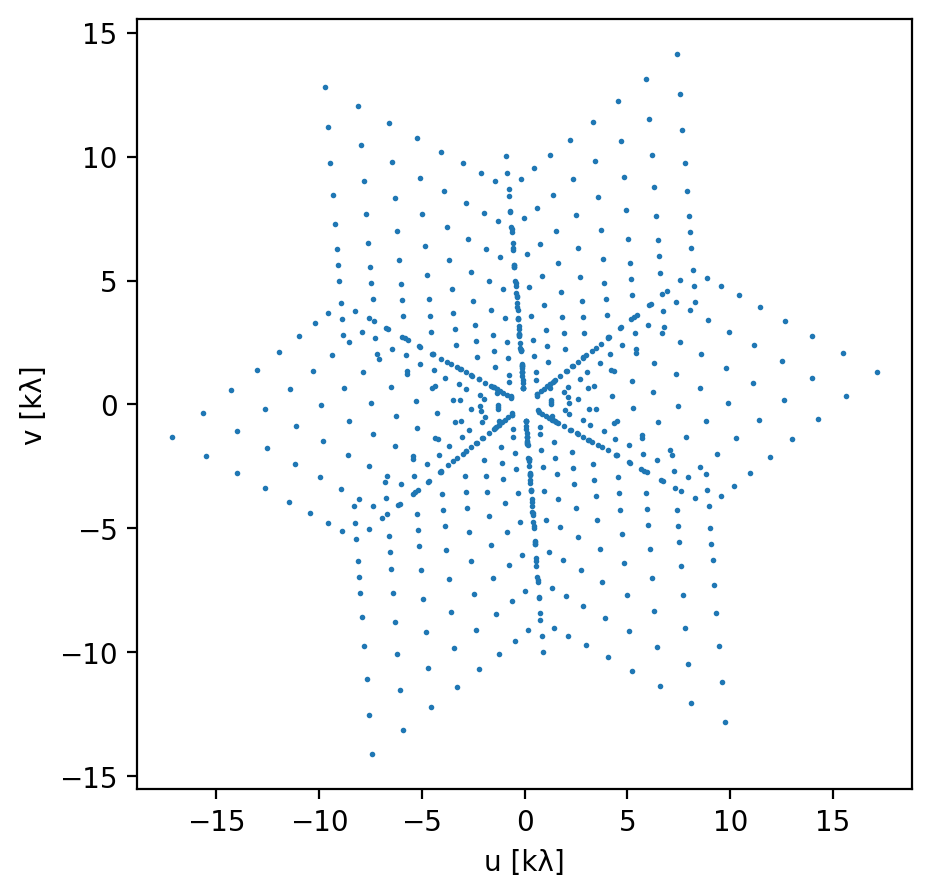

In [31]:
plt.figure(figsize=(5, 5))
plt.scatter(*zip(*uv_coverage), s=1)
plt.xlabel("u [kλ]")
plt.ylabel("v [kλ]")
plt.show()

## 3.2 One hour observation -0.5<H<0.5

- 1 hour
- HA = ± 0.5 hr
- data samples taken every 30 seconds

In [32]:
H_array = np.radians(np.arange(-0.5, 0.5, 30 / 3600) / 24 * 360)  # rad

In [33]:
uv_coverage = []
for H in H_array:
    for a, b in baselines:
        A = (np.radians(D_config.loc[a]["theta"]), D_config.loc[a]["R(m)"])
        B = (np.radians(D_config.loc[b]["theta"]), D_config.loc[b]["R(m)"])
        L, angle = polar_dist_angle(A, B)
        d, h = horz2eq(phi, A=angle)
        u, v = uv(L, wavelength, H, h, D, d)
        u /= 1e3  # kλ
        v /= 1e3  # kλ
        uv_coverage.append((u, v))
        uv_coverage.append((-u, -v))

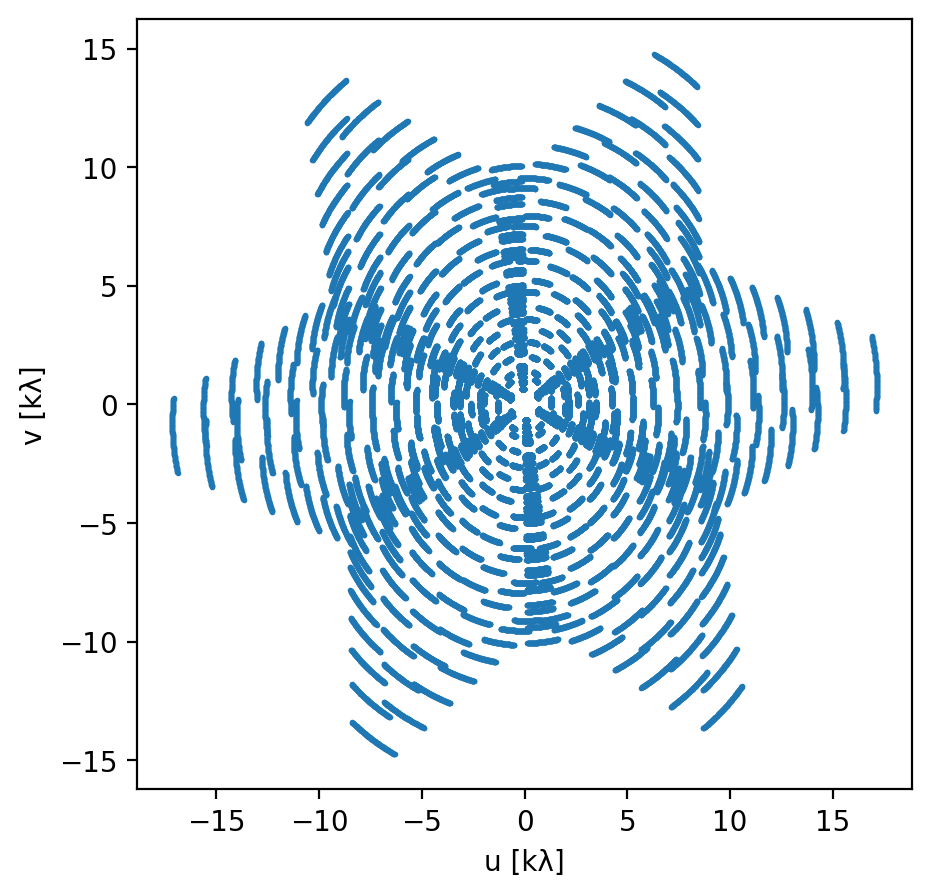

In [34]:
plt.figure(figsize=(5, 5))
plt.scatter(*zip(*uv_coverage), s=1)
plt.xlabel("u [kλ]")
plt.ylabel("v [kλ]")
plt.show()

## 3.3 Synthesized beam

Estimate the size of the synthesized beam (resolution) by $\theta_{1/2}\sim\lambda/D_{\rm max}$

The baseline from station `W9` to station `E9` could be the longest baseline.

In [35]:
D_config[(D_config["Station"] == "W9") | (D_config["Station"] == "E9")]

Station    R(m)       theta
8       W9  592.39  236.001389
17      E9  592.38  114.995000

In [36]:
W9 = (236.001389, 592.39)
E9 = (114.995000, 592.38)
D_max, theta = polar_dist_angle(W9, E9)
print(f"θ_1/2: {np.degrees(wavelength / D_max) * 3600:.2f} arcsec")

θ_1/2: 14.38 arcsec


To be more accurate, $D_{\rm max}/\lambda$ should be the maximum of $\sqrt{u^2+v^2}$ over UV-coverage.

In [37]:
θ = 1 / max([(i**2 + j**2) ** 0.5 * 1e3 for i, j in uv_coverage])
θ = np.degrees(θ) * 3600
print(f"θ_1/2: {θ:.2f} arcsec")

θ_1/2: 12.00 arcsec


## 3.4 Grid the UV plane

The synthesized beam is the Fourier transform of the UV-coverage.
Note:
- the pixel size of the dirty beam map is determined by the uv_max of the uv image
- the size of the dirty beam map is determined by the pixel size of the uv image

For example, if the pixel size of the uv image is $a$ (in the unit of λ), the size of the dirty beam map is thus $1/a$ rad.

In [38]:
uvmax = 20  # kλ
uv_pixel_size = 0.1  # kλ
nsize = int(2 * uvmax // uv_pixel_size)
uv_sample = np.zeros((nsize, nsize))
map_size = np.degrees(1 / uv_pixel_size / 1e3) * 3600 / 2  # arcsec
for uu, vv in uv_coverage:
    uu = int((uu + uvmax) / uvmax / 2 * nsize)
    vv = int((vv + uvmax) / uvmax / 2 * nsize)
    uv_sample[vv, uu] = 1

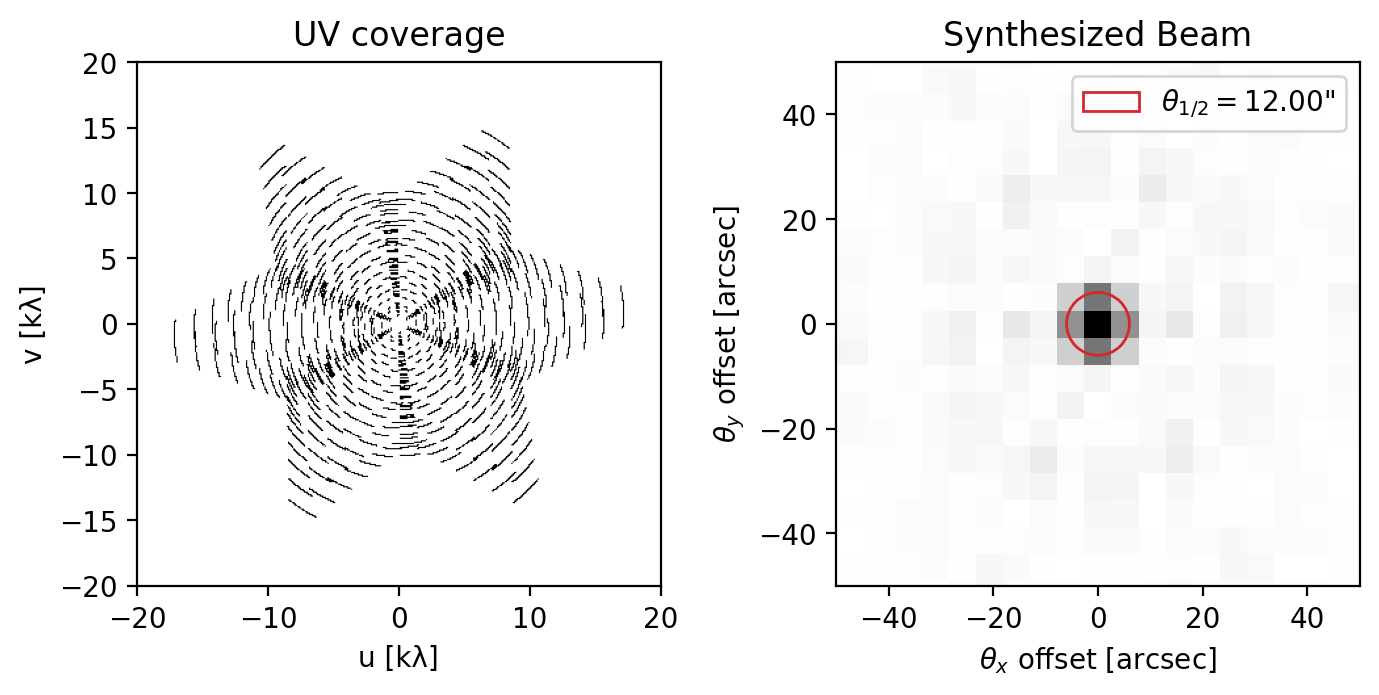

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
ax1.imshow(uv_sample, extent=[-uvmax, uvmax, -uvmax, uvmax])
ax1.set_xlabel("u [kλ]")
ax1.set_ylabel("v [kλ]")
ax1.set_title("UV coverage")

PSF = np.abs(fftpack.fftshift(fftpack.fftn(uv_sample)))
ax2.imshow(PSF, extent=[-map_size, map_size, -map_size, map_size])
PSFlim = 50
ax2.set_xlim(-PSFlim, PSFlim)
ax2.set_ylim(-PSFlim, PSFlim)
ax2.set_xlabel("$\\theta_x$ offset [arcsec]")
ax2.set_ylabel("$\\theta_y$ offset [arcsec]")
ax2.set_title("Synthesized Beam")
ax2.add_artist(
    plt.Circle(
        (0, 0), θ / 2, color="C3", fill=False, label=f'$\\theta_{{1/2}}={θ:.2f}$"'
    )
)
ax2.legend()
f.tight_layout()

In order to get the finer structure of the synthesized beam, we need samller pixel size in the dirty beam map, which requires larger uv_max of the uv image. We can surely include more uv-coverage because we know that they are all zeros in the outer region of the uv-plane. In fact, we can include as much as we want to get a smooth enough PSF.

In [40]:
uvmax = 100  # kλ
uv_pixel_size = 0.1  # kλ
nsize = int(2 * uvmax // uv_pixel_size)
uv_sample = np.zeros((nsize, nsize))
map_size = np.degrees(1 / uv_pixel_size / 1e3) * 3600 / 2  # arcsec
for uu, vv in uv_coverage:
    uu = int((uu + uvmax) / uvmax / 2 * nsize)
    vv = int((vv + uvmax) / uvmax / 2 * nsize)
    uv_sample[vv, uu] = 1

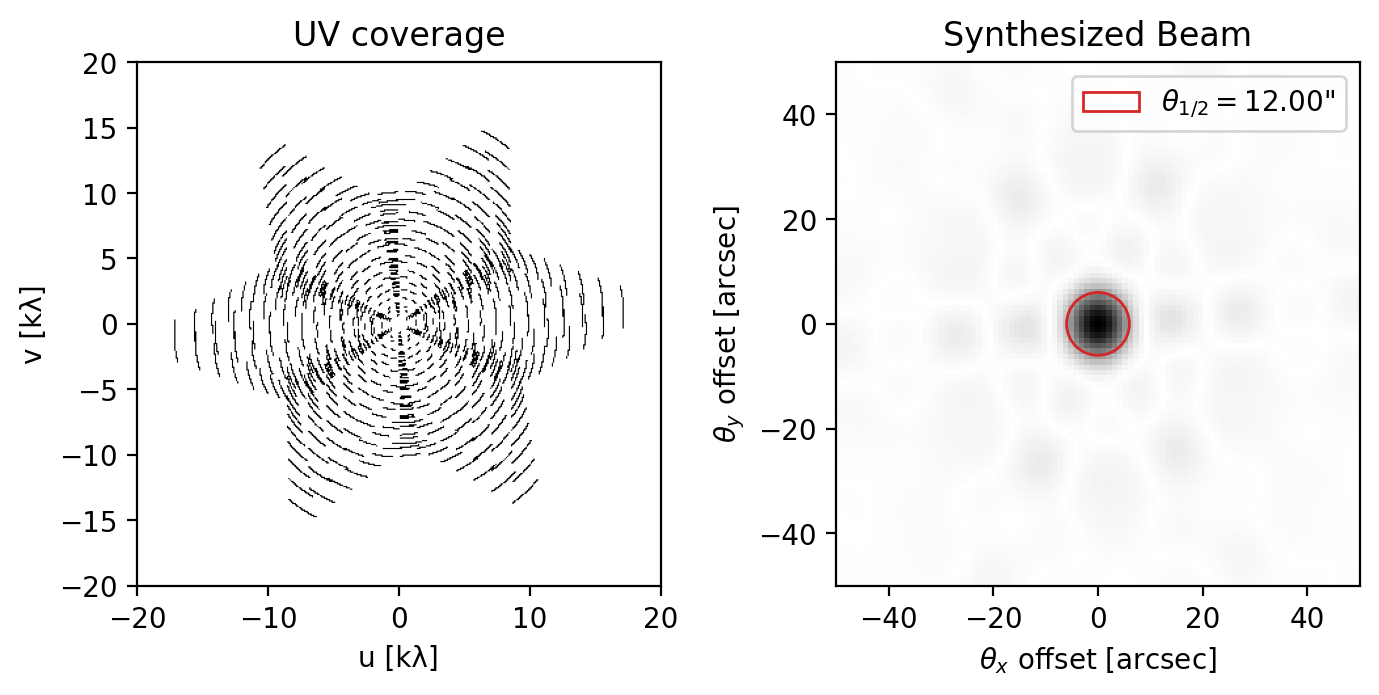

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
ax1.imshow(uv_sample, extent=[-uvmax, uvmax, -uvmax, uvmax])
uvlim = 20
ax1.set_xlim(-uvlim, uvlim)
ax1.set_ylim(-uvlim, uvlim)
ax1.set_xlabel("u [kλ]")
ax1.set_ylabel("v [kλ]")
ax1.set_title("UV coverage")

PSF = np.abs(fftpack.fftshift(fftpack.fftn(uv_sample)))
ax2.imshow(PSF, extent=[-map_size, map_size, -map_size, map_size])
PSFlim = 50
ax2.set_xlim(-PSFlim, PSFlim)
ax2.set_ylim(-PSFlim, PSFlim)
ax2.set_xlabel("$\\theta_x$ offset [arcsec]")
ax2.set_ylabel("$\\theta_y$ offset [arcsec]")
ax2.set_title("Synthesized Beam")
ax2.add_artist(
    plt.Circle(
        (0, 0), θ / 2, color="C3", fill=False, label=f'$\\theta_{{1/2}}={θ:.2f}$"'
    )
)
ax2.legend()
f.tight_layout()

The profile of the synthesized beam is plotted below and the FWHM is in consistent with the previous estimation 12.00".

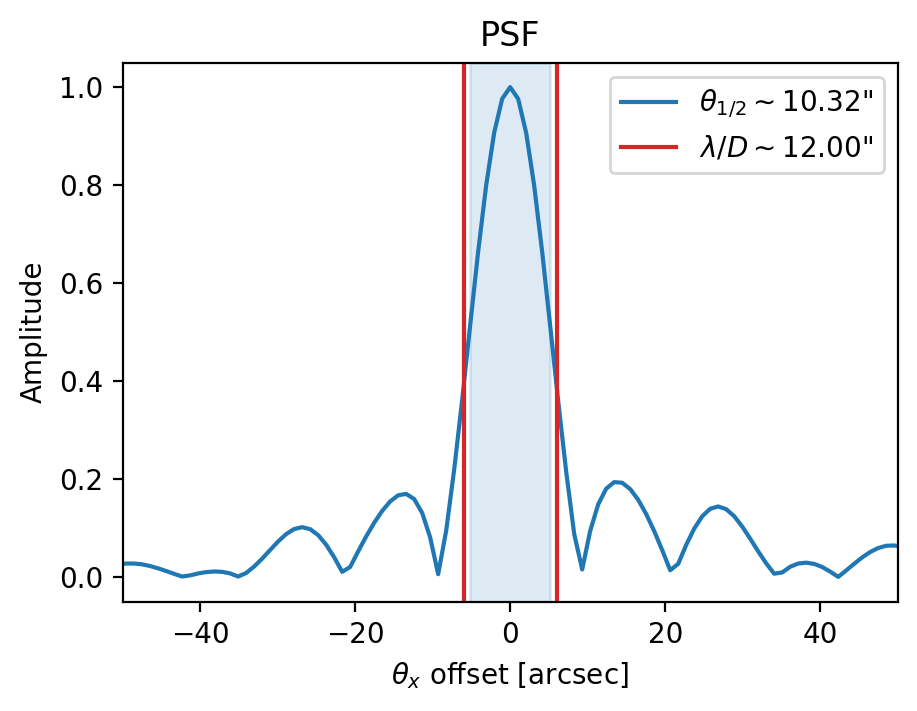

In [42]:
PSF_profile = PSF[PSF.shape[0] // 2 + 1, :]
PSF_profile /= PSF_profile.max()
x = np.linspace(-map_size, map_size, PSF.shape[0])
# Find FWHM
idx1 = (np.abs(PSF_profile[: len(PSF_profile) // 2] - 0.5)).argmin()
idx2 = (np.abs(PSF_profile[len(PSF_profile) // 2 :] - 0.5)).argmin()
idx2 += len(PSF_profile) // 2

plt.figure(figsize=(5, 3.5))
plt.plot(x, PSF_profile, label=f'$\\theta_{{1/2}}\sim{x[idx2]-x[idx1]:.2f}$"')
plt.axvspan(x[idx1], x[idx2], alpha=0.15, color="C0")
plt.axvline(θ / 2, color="C3", label=f'$\lambda/D\sim{θ:.2f}$"')
plt.axvline(-θ / 2, color="C3")
plt.xlim(-50, 50)
plt.title("PSF")
plt.xlabel("$\\theta_x$ offset [arcsec]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# 4. True sky

## 4.1 Field of view (Primary beam)

$\theta_{\rm FoV}=1.15\dfrac\lambda d$ → $\Omega_{\rm FOV}=1.5\left(\dfrac\lambda d\right)^2$

$d$: diameter of each antenna. For VLA, it's 25 meters (81 feet)

In [43]:
FoV = np.degrees(1.15 * wavelength / 25)
print(f"θ_FoV: {FoV:.2f}°")

θ_FoV: 0.16°


The physical size of the field of view is obtained. To get the exact RA coverage, the conversion discussed in Section 0.6 is needed. Note source 1 (J 05 00 00 + 45 00 00) is at the centre of the field of view.

In [44]:
centre_RA = 5 / 24 * 360  # degree
centre_Dec = np.degrees(D)  # degree
extent = [-FoV / 2, FoV / 2, -FoV / 2, FoV / 2]
extent_RA_Dec = [
    -FoV / 2 / np.cos(D) + centre_RA,
    FoV / 2 / np.cos(D) + centre_RA,
    -FoV / 2 + centre_Dec,
    FoV / 2 + centre_Dec,
]
extent_RA_Dec_offset = [
    -FoV / 2 / np.cos(D),
    FoV / 2 / np.cos(D),
    -FoV / 2,
    FoV / 2,
]
extent_RA_Dec_offset = np.array(extent_RA_Dec_offset) * 3600

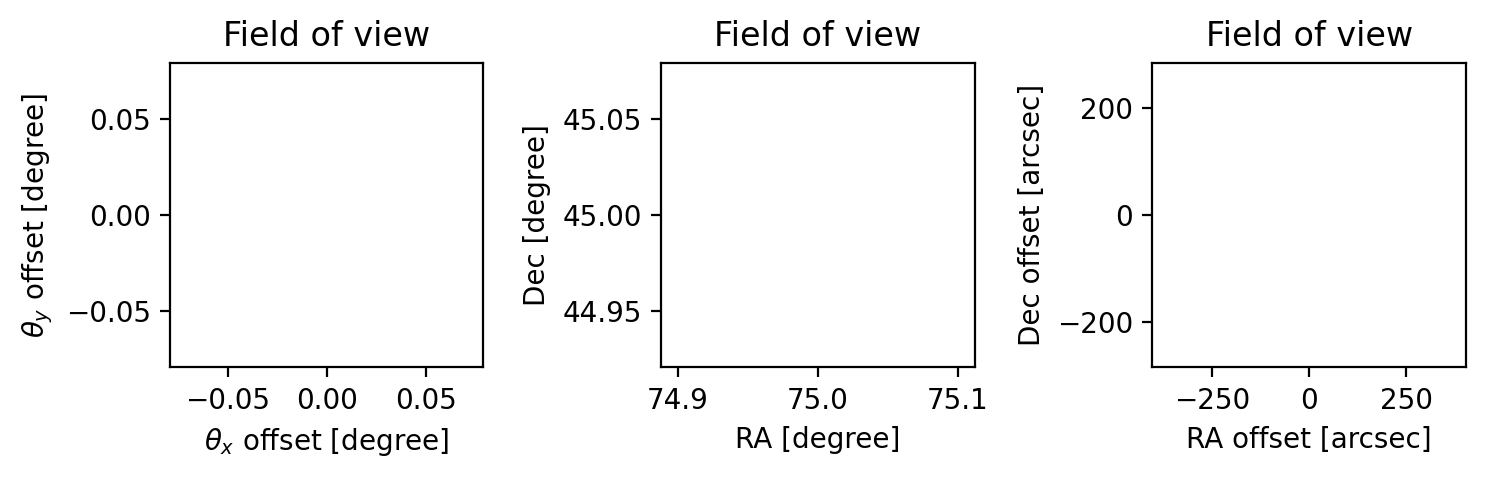

In [45]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7.55, 2.5))
ax1.imshow(np.zeros((2, 2)), extent=extent, aspect="auto")
ax1.set_title("Field of view")
ax1.set_xlabel("$\\theta_x$ offset [degree]")
ax1.set_ylabel("$\\theta_y$ offset [degree]")
ax2.imshow(np.zeros((2, 2)), extent=extent_RA_Dec, aspect="auto")
ax2.set_title("Field of view")
ax2.set_xlabel("RA [degree]")
ax2.set_ylabel("Dec [degree]")
ax3.imshow(np.zeros((2, 2)), extent=extent_RA_Dec_offset, aspect="auto")
ax3.set_title("Field of view")
ax3.set_xlabel("RA offset [arcsec]")
ax3.set_ylabel("Dec offset [arcsec]")
f.tight_layout()

In [46]:
sky = np.zeros((1000, 1000))
x = 10  # J050010+450300
y = 3 * 60  # J050010+450300
xx = round(x / extent_RA_Dec_offset[1] * sky.shape[1] / 2)
yy = round(y / extent_RA_Dec_offset[3] * sky.shape[0] / 2)
sky[sky.shape[0] // 2, sky.shape[0] // 2] = 3.6  # 3.6 Jy
sky[sky.shape[0] // 2 + yy, sky.shape[0] // 2 + xx] = 5.8  # 5.8 Jy

Because the sources are delta functions and the pixel size is too small, it's hard to see the sources in the whole FoV image. Zoomed in regions are plotted respectively.

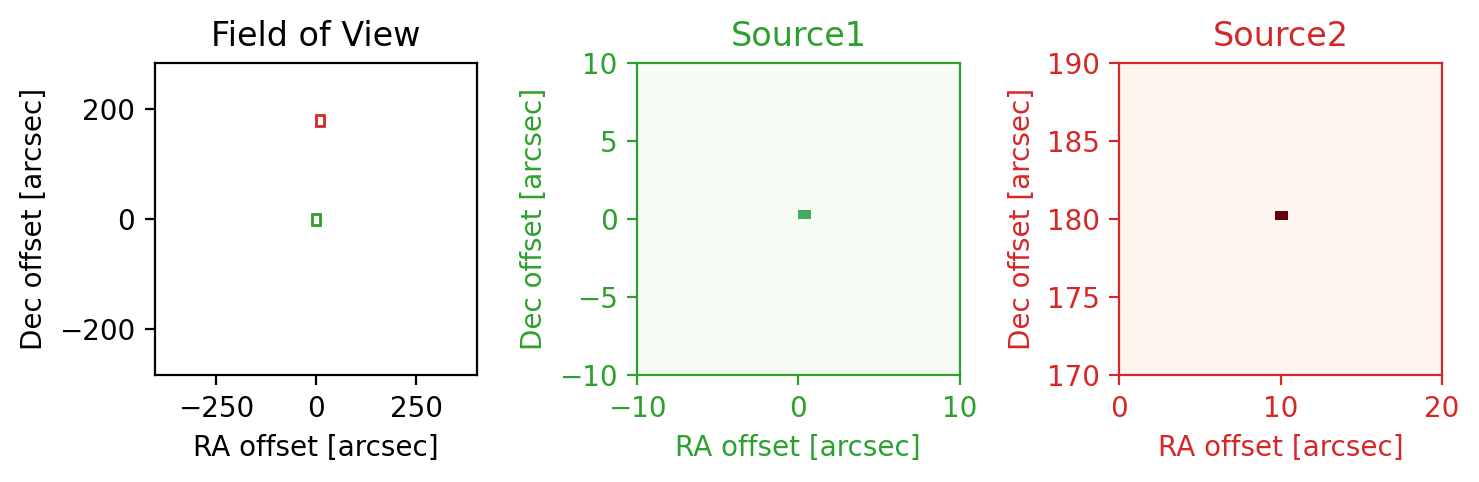

In [47]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7.5, 2.5))
ax1.imshow(sky, extent=extent_RA_Dec_offset, aspect="auto")
ax1.set_xlabel("RA offset [arcsec]")
ax1.set_ylabel("Dec offset [arcsec]")
ax1.set_title("Field of View")

rect1 = patches.Rectangle(
    (-10, -10), 20, 20, linewidth=1, edgecolor="C2", facecolor="none"
)
rect2 = patches.Rectangle(
    (0, 170), 20, 20, linewidth=1, edgecolor="C3", facecolor="none"
)
ax1.add_patch(rect1)
ax1.add_patch(rect2)

ax2.tick_params(color="C2", labelcolor="C2")
for spine in ax2.spines.values():
    spine.set_edgecolor("C2")

ax3.tick_params(color="C3", labelcolor="C3")
for spine in ax3.spines.values():
    spine.set_edgecolor("C3")

for ax, c, cmap in zip([ax2, ax3], ["C2", "C3"], ["Greens", "Reds"]):
    ax.imshow(sky, extent=extent_RA_Dec_offset, cmap=cmap, aspect="auto")
    ax.set_xlabel("RA offset [arcsec]", c=c)
    ax.set_ylabel("Dec offset [arcsec]", c=c)

ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.set_title("Source1", c="C2")
ax3.set_xlim(0, 20)
ax3.set_ylim(170, 190)
ax3.set_title("Source2", c="C3")
f.tight_layout()
plt.show()

## 4.2 Fourier transform of the true sky brightness

The size of the uv-plane (uv_max) is determined by the pixel size of the true sky image.

For example, if the pixel size of the true sky image is $a$ rad, the size of the uv-plane is thus $1/a$ (in the unit of λ).

In [48]:
sky_FT = fftpack.fftshift(fftpack.fftn(sky))
sky_pixel_size = np.radians(((extent[1] - extent[0]) / sky.shape[1]))
uv_img_size = 1 / sky_pixel_size / 1e3  # kλ

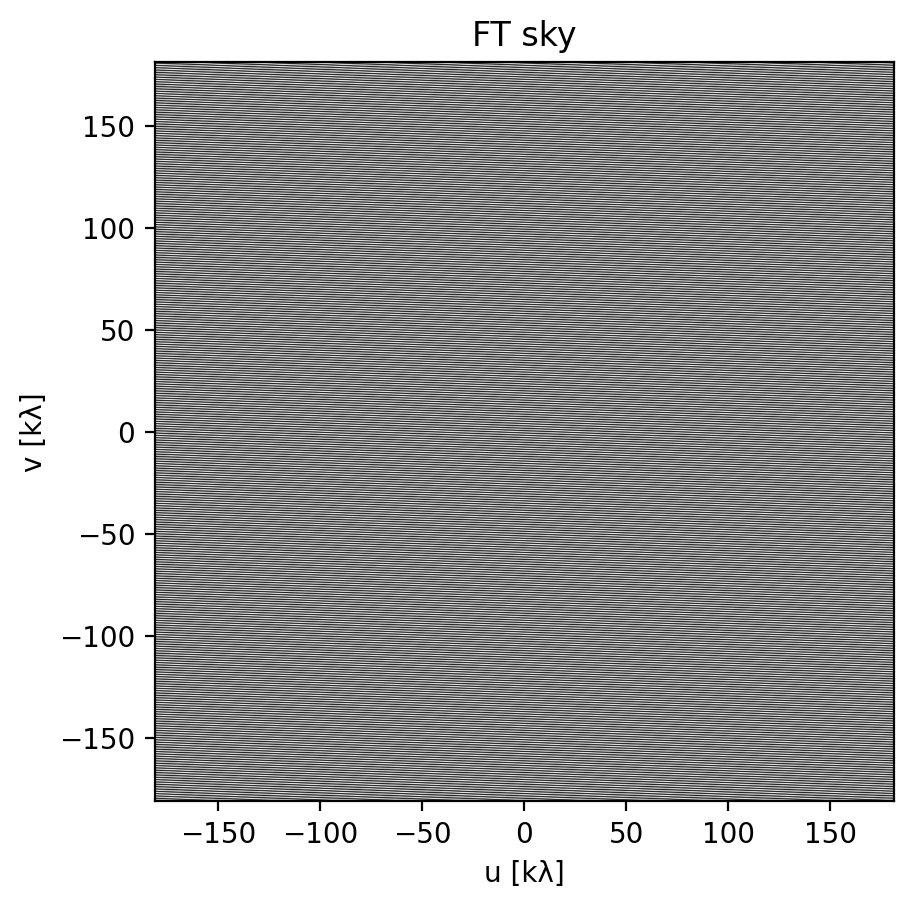

In [49]:
plt.imshow(
    np.abs(sky_FT),
    extent=[-uv_img_size / 2, uv_img_size / 2, -uv_img_size / 2, uv_img_size / 2],
)
plt.xlabel("u [kλ]")
plt.ylabel("v [kλ]")
plt.title("FT sky")
plt.show()

The the Fourier transform of double-point sources is sinusoidal fringes.

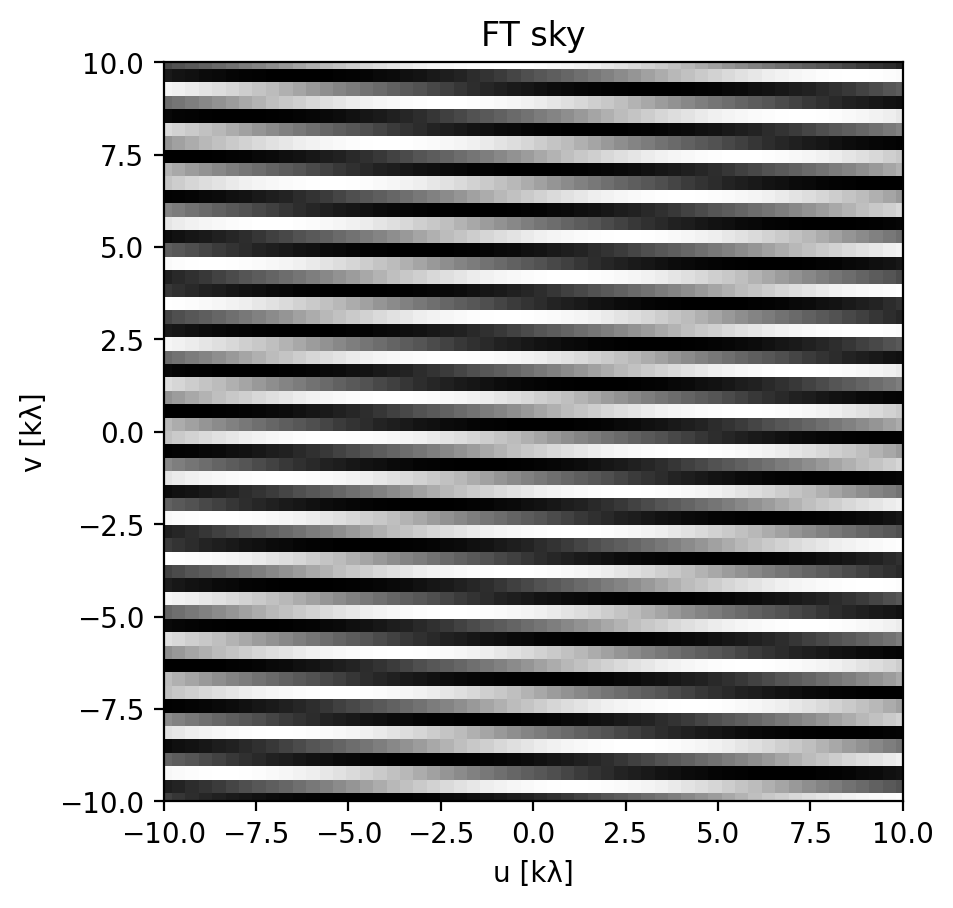

In [50]:
plt.imshow(
    np.abs(sky_FT),
    extent=[-uv_img_size / 2, uv_img_size / 2, -uv_img_size / 2, uv_img_size / 2],
)
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.xlabel("u [kλ]")
plt.ylabel("v [kλ]")
plt.title("FT sky")
plt.show()

# 5. Visibility
The visibility is the Fourier transform of the true sky brightness multiplied by the sampling function (UV-coveraage).
<center><img src=https://i.imgur.com/tTj7KY6.png width="500"></center>

Note: The size of the FT sky should match the size of the uv-coverage image so as to be multiplied by the sampling function.

In [51]:
uvmax = uv_img_size // 2  # kλ
uv_sample = np.zeros_like(sky_FT)
for uu, vv in uv_coverage:
    uu = int((uu + uvmax) / uvmax / 2 * uv_sample.shape[1])
    vv = int((vv + uvmax) / uvmax / 2 * uv_sample.shape[0])
    uv_sample[vv, uu] = 1

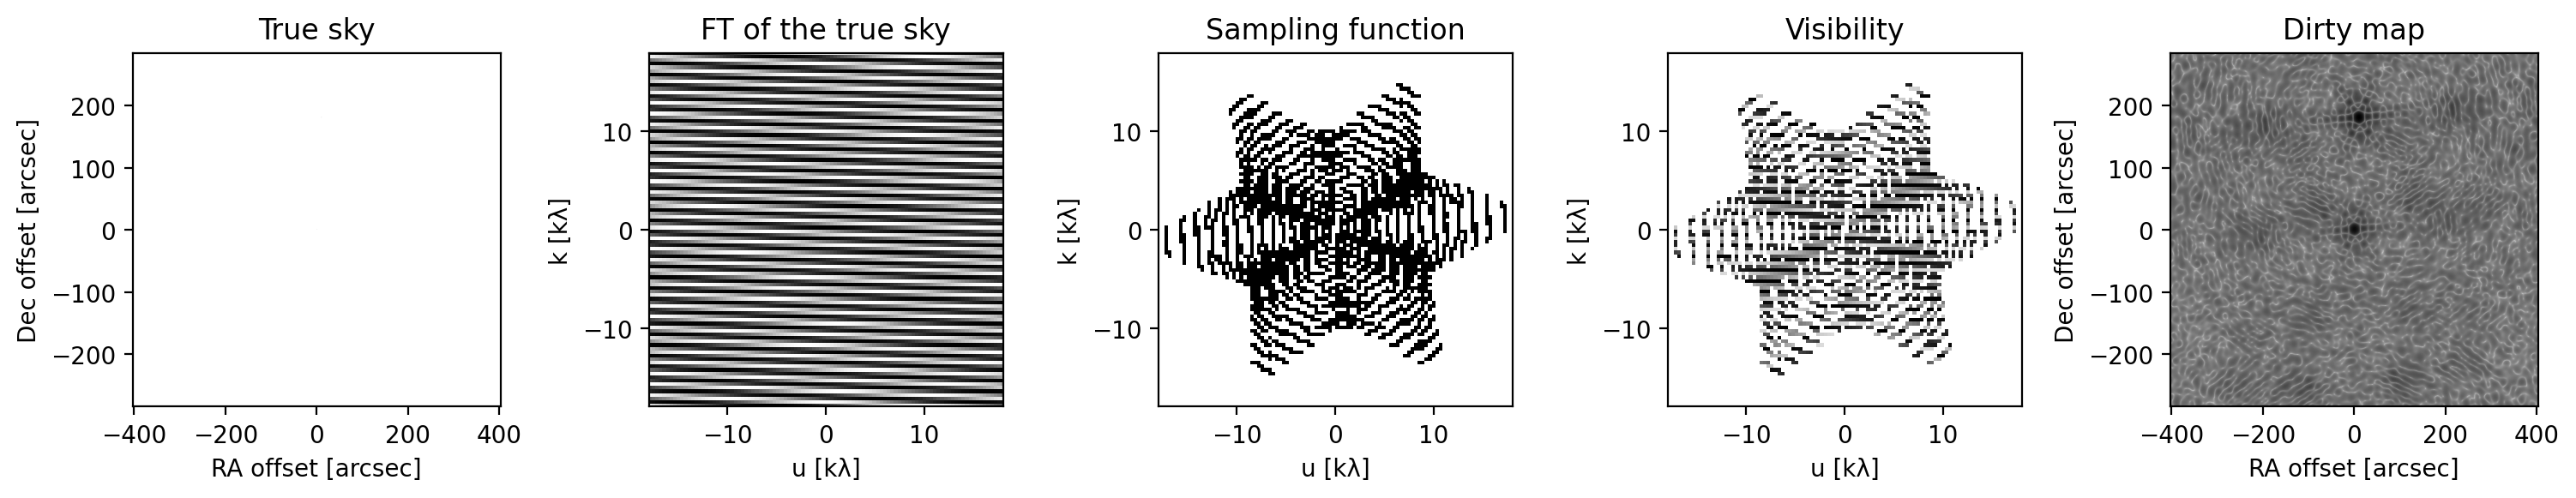

In [52]:
visibility = sky_FT * uv_sample
dirty_map = fftpack.ifftn(visibility)

f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(15, 3))
ax0.imshow(sky, extent=extent_RA_Dec_offset, aspect="auto")
ax0.set_xlabel("RA offset [arcsec]")
ax0.set_ylabel("Dec offset [arcsec]")
ax0.set_title("True sky")

ax1.imshow(np.abs(sky_FT), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax1.set_title("FT of the true sky")

ax2.imshow(np.abs(uv_sample), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax2.set_title("Sampling function")

ax3.imshow(np.abs(visibility), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax3.set_title("Visibility")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("u [kλ]")
    ax.set_ylabel("k [kλ]")
    ax.set_xlim([-18, 18])
    ax.set_ylim([-18, 18])

ax4.imshow(np.log(np.abs(dirty_map)), extent=extent_RA_Dec_offset, aspect="auto")
ax4.set_xlabel("RA offset [arcsec]")
ax4.set_ylabel("Dec offset [arcsec]")
ax4.set_title("Dirty map")
f.tight_layout()
plt.show()

## 5.1 Real and imaginary components of the “observed” data

These two sources have different flux densities, but we can still consider a pair of points with flux 3.6 Jy plus a single point with flux 2.2 Jy at the position of Source2. According to the discussion in Section 0.4, A single point corresponds to sinusoidal fringes in both real and imaginary components, while a pair of points would only have real component.

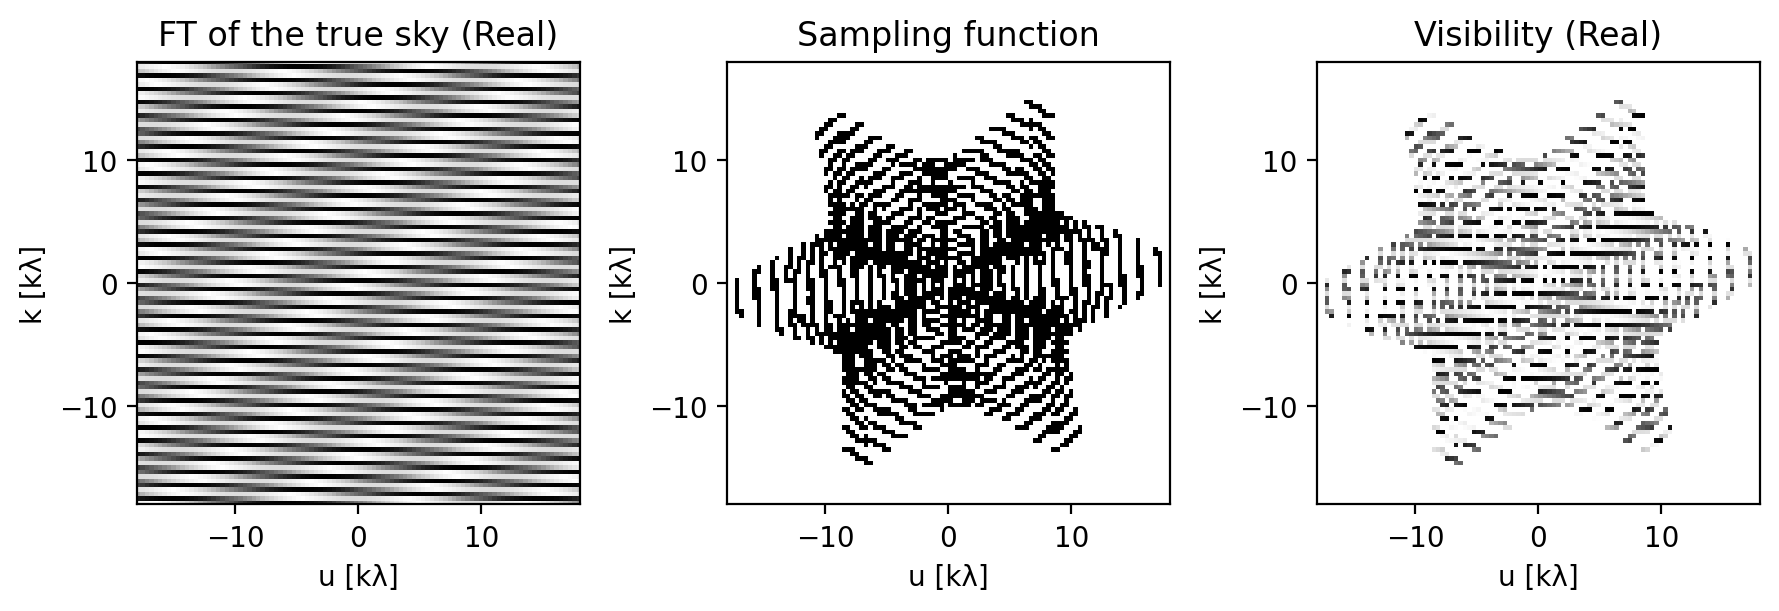

In [53]:
visibility = sky_FT * uv_sample
dirty_map = fftpack.ifftn(visibility)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

ax1.imshow(np.abs(np.real(sky_FT)), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax1.set_title("FT of the true sky (Real)")

ax2.imshow(np.abs(uv_sample), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax2.set_title("Sampling function")

ax3.imshow(np.abs(np.real(visibility)), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax3.set_title("Visibility (Real)")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("u [kλ]")
    ax.set_ylabel("k [kλ]")
    ax.set_xlim([-18, 18])
    ax.set_ylim([-18, 18])

f.tight_layout()
plt.show()

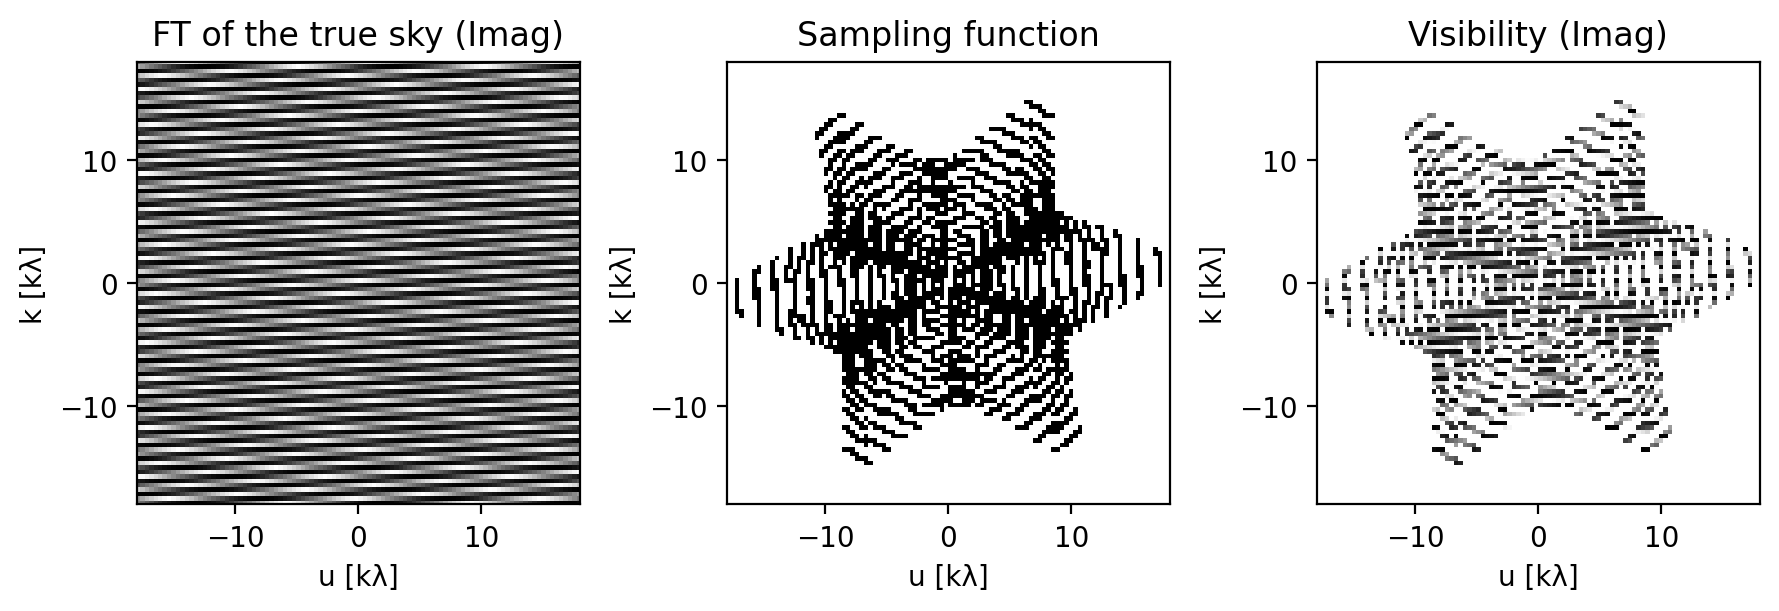

In [54]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

ax1.imshow(np.abs(np.imag(sky_FT)), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax1.set_title("FT of the true sky (Imag)")

ax2.imshow(np.abs(uv_sample), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax2.set_title("Sampling function")

ax3.imshow(np.abs(np.imag(visibility)), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax3.set_title("Visibility (Imag)")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("u [kλ]")
    ax.set_ylabel("k [kλ]")
    ax.set_xlim([-18, 18])
    ax.set_ylim([-18, 18])

f.tight_layout()
plt.show()

### 5.1.1 Experiment
We can do an experiment with two sources which have same flux.

In [55]:
sky_test = np.zeros((1000, 1000))
x = 10
y = 0
xx = round(x / extent_RA_Dec_offset[1] * sky_test.shape[1] / 2)
yy = round(y / extent_RA_Dec_offset[3] * sky_test.shape[0] / 2)
sky_test[sky_test.shape[0] // 2, sky_test.shape[0] // 2] = 1
sky_test[sky_test.shape[0] // 2 + yy, sky_test.shape[0] // 2 + xx] = 1
sky_test_FT = fftpack.fftshift(fftpack.fftn(sky_test))

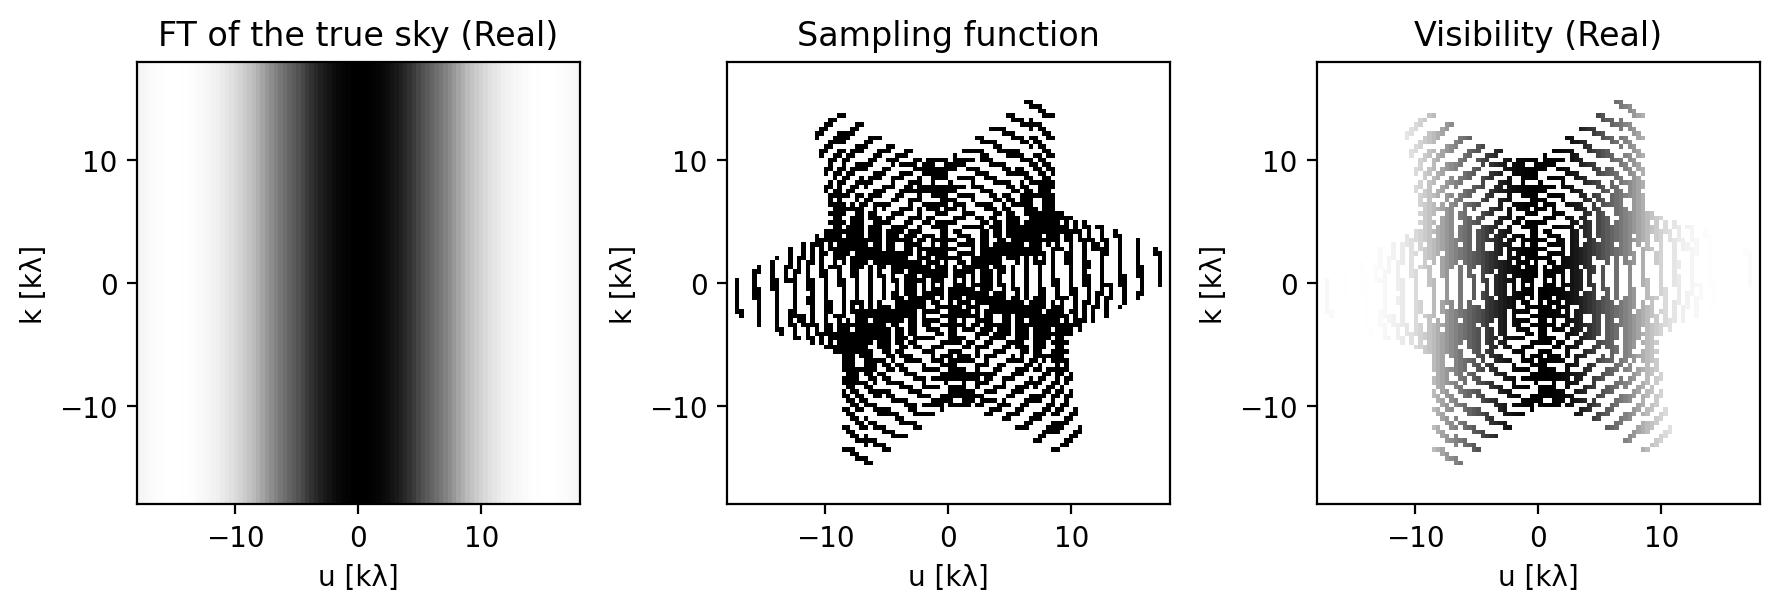

In [56]:
visibility_test = sky_test_FT * uv_sample
dirty_map_test = fftpack.ifftn(visibility_test)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

ax1.imshow(np.abs(np.real(sky_test_FT)), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax1.set_title("FT of the true sky (Real)")

ax2.imshow(np.abs(uv_sample), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax2.set_title("Sampling function")

ax3.imshow(np.abs(np.real(visibility_test)), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax3.set_title("Visibility (Real)")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("u [kλ]")
    ax.set_ylabel("k [kλ]")
    ax.set_xlim([-18, 18])
    ax.set_ylim([-18, 18])

f.tight_layout()
plt.show()

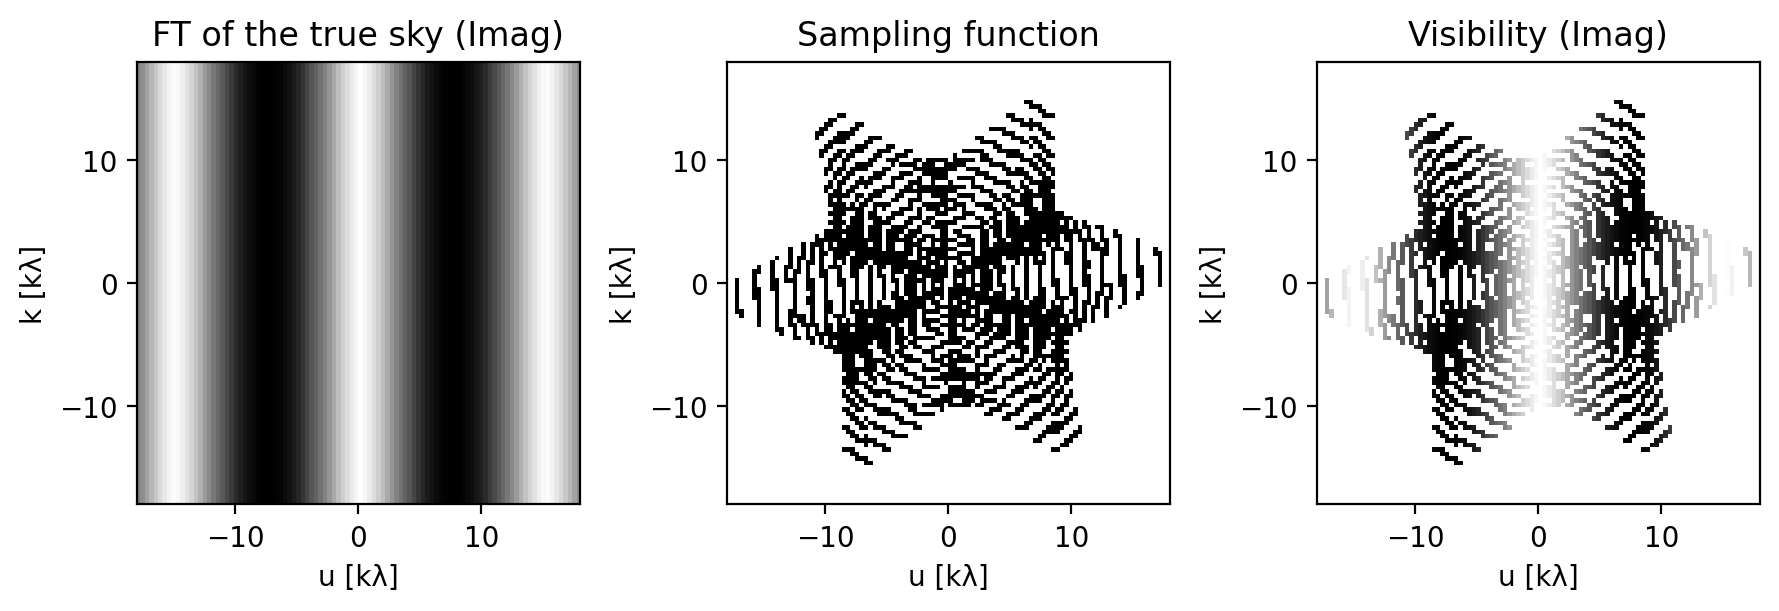

In [57]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

ax1.imshow(np.abs(np.imag(sky_test_FT)), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax1.set_title("FT of the true sky (Imag)")

ax2.imshow(np.abs(uv_sample), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax2.set_title("Sampling function")

ax3.imshow(np.abs(np.imag(visibility_test)), extent=[-uvmax, uvmax, -uvmax, uvmax])
ax3.set_title("Visibility (Imag)")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("u [kλ]")
    ax.set_ylabel("k [kλ]")
    ax.set_xlim([-18, 18])
    ax.set_ylim([-18, 18])

f.tight_layout()
plt.show()

## 5.2 Measured positions and flux

In [58]:
observation = np.abs(dirty_map)
yy1, xx1 = np.where(observation == observation.max())
yy2, xx2 = np.where(observation == observation[300:600, :].max())
x1 = (
    xx1 / observation.shape[1] * (extent_RA_Dec[1] - extent_RA_Dec[0])
    + extent_RA_Dec[0]
)
y1 = (
    yy1 / observation.shape[0] * (extent_RA_Dec[3] - extent_RA_Dec[2])
    + extent_RA_Dec[2]
)
x2 = (
    xx2 / observation.shape[1] * (extent_RA_Dec[1] - extent_RA_Dec[0])
    + extent_RA_Dec[0]
)
y2 = (
    yy2 / observation.shape[0] * (extent_RA_Dec[3] - extent_RA_Dec[2])
    + extent_RA_Dec[2]
)

In [59]:
print(
    f"Source1: RA={x2[0]/360*24:.2f}h {(x2[0]-75)*60//1:.2f}m {(x2[0]-75)*60%1*60:.2f}s, Dec={y2[0]//1:.2f}° {y2[0]%1*60//1:.2f}m {y2[0]%1*60%1*60:.2f}s "
)
print(
    f"Source2: RA={x1[0]/360*24:.2f}h {(x1[0]-75)*60//1:.2f}m {(x1[0]-75)*60%1*60:.2f}s, Dec={y1[0]//1:.2f}° {y1[0]%1*60//1:.2f}m {y1[0]%1*60%1*60:.2f}s "
)

Source1: RA=5.00h 0.00m 0.00s, Dec=45.00° 0.00m 0.00s 
Source2: RA=5.00h 0.00m 9.66s, Dec=45.00° 2.00m 59.90s 


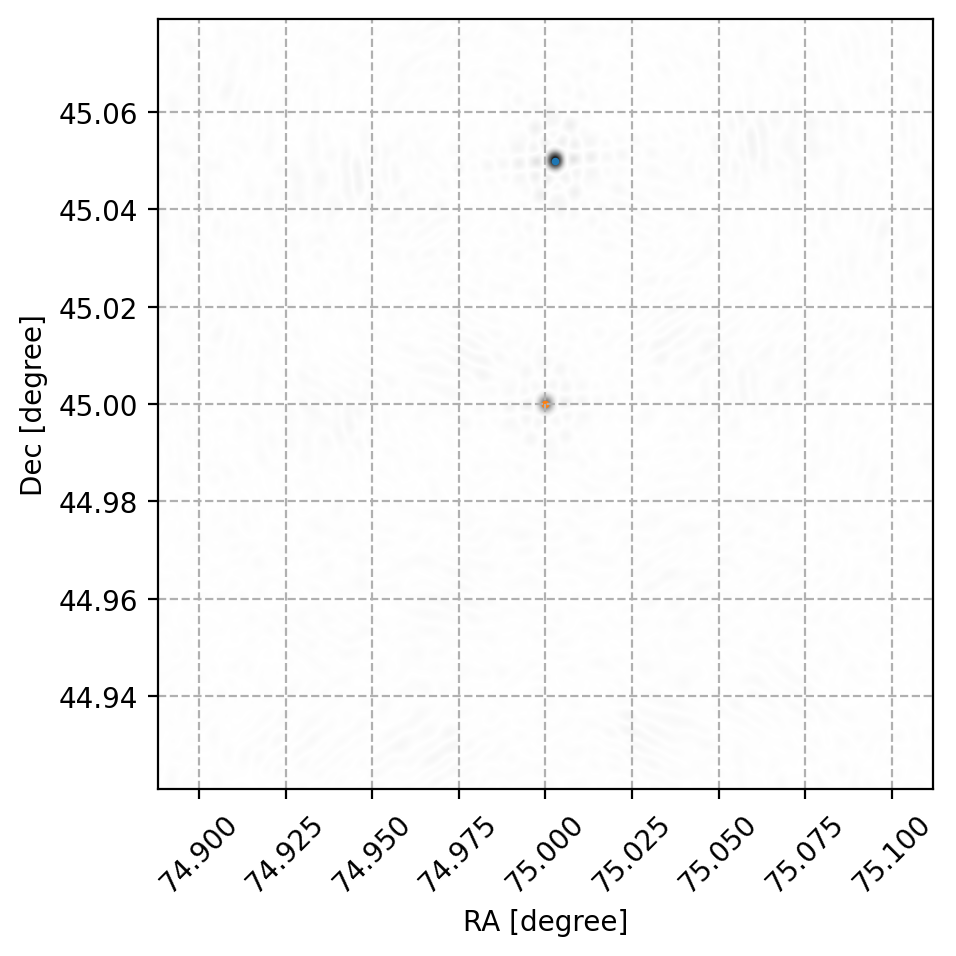

In [60]:
plt.figure(figsize=(5, 5))
plt.imshow(observation, extent=extent_RA_Dec, aspect="auto")
plt.scatter(x1, y1, s=3)
plt.scatter(x2, y2, s=3)
plt.xlabel("RA [degree]")
plt.ylabel("Dec [degree]")
plt.xticks(rotation=45)
plt.grid(ls="--")
plt.show()

In [61]:
nbin = round(observation.shape[1] * θ / 3600 / (extent_RA_Dec[1] - extent_RA_Dec[0]))
xx, yy = np.meshgrid(np.arange(observation.shape[1]), np.arange(observation.shape[0]))
r1 = np.hypot(xx - xx1, yy - yy1)
r2 = np.hypot(xx - xx2, yy - yy2)

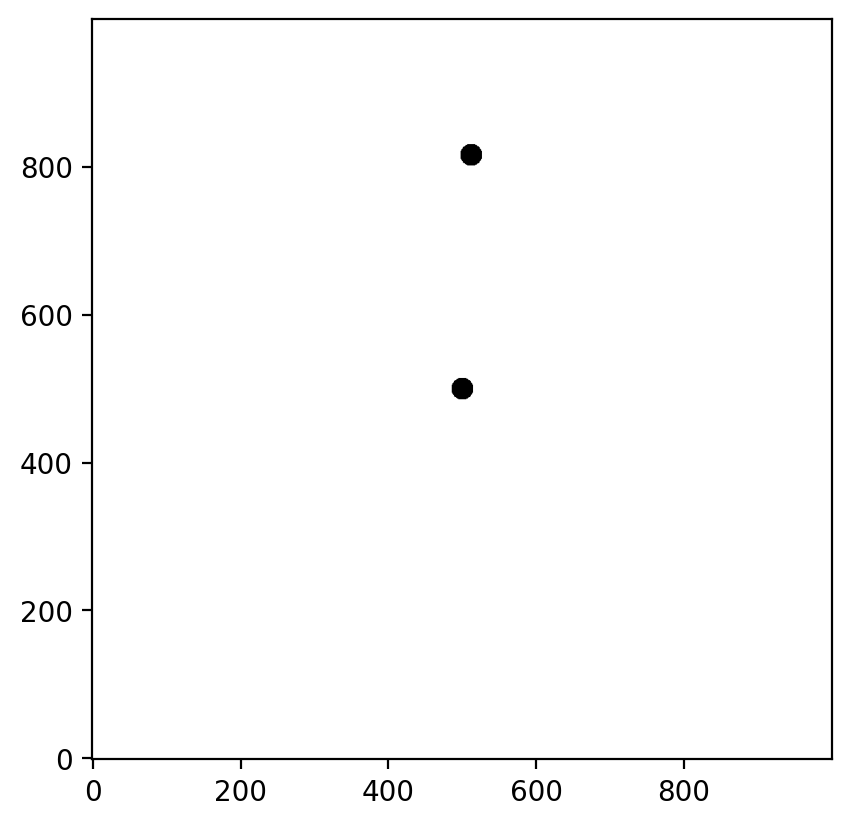

In [62]:
plt.imshow((r1 < nbin) + (r2 < nbin))
plt.show()

In order to get the flux density, we need to sum up the flux in the PSF.

In [63]:
flux1 = np.sum(observation * (r2 < nbin))
flux2 = np.sum(observation * (r1 < nbin))
print(f"Source1: {flux1:.2f}")
print(f"Source2: {flux2:.2f}")

Source1: 2.97
Source2: 4.79


If the use Source1 (3.6 Jy) as calibrator, we will get the flux of Source2

In [64]:
print(f"Source2: {flux2 / flux1 * 3.6:.2f} Jy")

Source2: 5.79 Jy


# 6. Convolution theorem

Another approach to get the dirty map is using convolution. The dirty map observed by an interferometer is the convolution of the true sky brightness distribution and the dirty beam (PSF) of the interferometer.

<center><img src=https://i.imgur.com/tTj7KY6.png width="500"></center>

In [65]:
uvmax = 100  # kλ
uv_pixel_size = 0.1  # kλ
nsize = int(2 * uvmax // uv_pixel_size)
uv_sample = np.zeros((nsize, nsize))
map_size = np.degrees(1 / uv_pixel_size / 1e3) * 3600 / 2  # arcsec
for uu, vv in uv_coverage:
    uu = int((uu + uvmax) / uvmax / 2 * nsize)
    vv = int((vv + uvmax) / uvmax / 2 * nsize)
    uv_sample[vv, uu] = 1

In [66]:
PSF = np.abs(fftpack.fftshift(fftpack.fftn(uv_sample)))

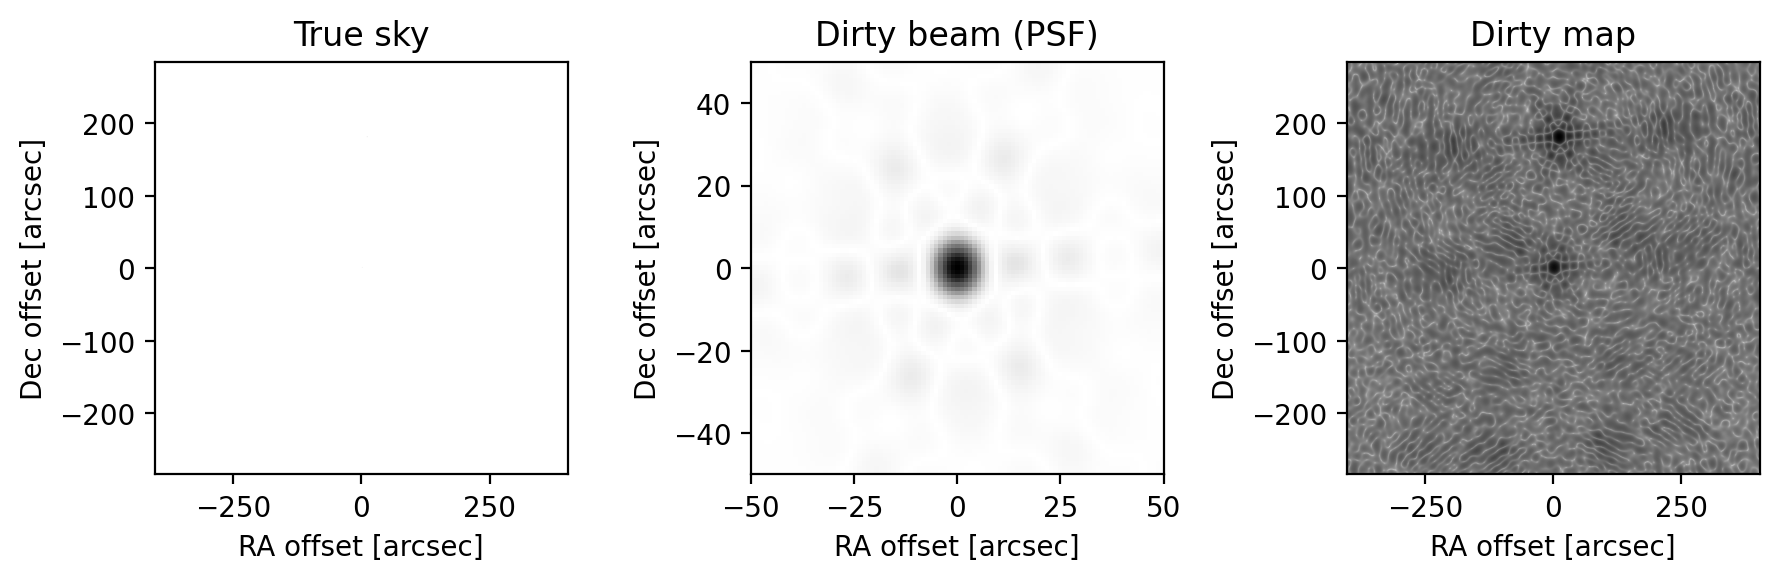

In [67]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(sky, extent=extent_RA_Dec_offset, aspect="auto")
ax1.set_title("True sky")
ax2.imshow(PSF, extent=[-map_size, map_size, -map_size, map_size])
ax2.set_xlim(-50, 50)
ax2.set_ylim(-50, 50)
ax2.set_title("Dirty beam (PSF)")

ax3.imshow(np.log(np.abs(dirty_map)), extent=extent_RA_Dec_offset, aspect="auto")
ax3.set_title("Dirty map")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("RA offset [arcsec]")
    ax.set_ylabel("Dec offset [arcsec]")

f.tight_layout()
plt.show()